In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from glob import glob
import cv2

In [21]:
training_paths = glob('dataset\\training_data\\images\\*.png')
len(training_paths)

149

# Read Image

In [22]:
training_paths = glob('dataset\\training_data\\images\\*.png')
len(training_paths)

149

In [23]:
def convert_to_binary(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    return thresh

In [24]:
def filter_small_blobs(thresh, min_size=100):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)
    new_thresh = thresh.copy()
    for i in range(1, num_labels):
        blob = labels == i
        if blob.sum() <= min_size:
            new_thresh[blob] = 0

    return new_thresh

In [25]:
def convert_to_components(thresh, kernel_size=5, iterations=2):

    # dilate the image to connect the components
    kernel = np.ones((kernel_size, kernel_size),np.uint8)
    dilated_image = cv2.dilate(thresh, kernel, iterations = iterations)

    # find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilated_image, connectivity=4)

    # combine labels with thresh img. Ink is written in it's blob number
    # Make labels 0 where thresh is 0
    labels[thresh == 0] = 0

    return labels, num_labels, stats, dilated_image

In [26]:
def move_objects(labels, max_dx=40, max_dy=40):
    transformed_img = np.zeros_like(labels)
    random_order_labels = np.unique(labels)[1:]
    np.random.shuffle(random_order_labels)
    new_labels = np.zeros_like(labels)
    for i in random_order_labels:
        blob = labels == i
        blob_idx = np.argwhere(blob)

        num_tries = 0
        while True:
            if num_tries > 300:
                print('too many tries')
                transformed_img[blob_idx[:,0], blob_idx[:,1]] = 1
                new_labels[blob_idx[:,0], blob_idx[:,1]] = i
                break

            if max_dx == 0 and max_dy == 0:
                dx = 0
                dy = 0
            else:
                dx = np.random.randint(2, max_dx) * np.random.choice([-1, 1])
                dy = np.random.randint(2, max_dy) * np.random.choice([-1, 1])

            new_blob_idx = blob_idx + np.array([dy, dx])
            # if all new blob idx are in bounds
            if (new_blob_idx[:,0] >= 0).all() and (new_blob_idx[:,0] < transformed_img.shape[0]).all() and (new_blob_idx[:,1] >= 0).all() and (new_blob_idx[:,1] < transformed_img.shape[1]).all():
                if transformed_img[new_blob_idx[:,0], new_blob_idx[:,1]].sum() == 0:
                    transformed_img[new_blob_idx[:,0], new_blob_idx[:,1]] = 1
                    new_labels[new_blob_idx[:,0], new_blob_idx[:,1]] = i
                    break
            num_tries += 1

    return transformed_img, new_labels

In [27]:
def make_changes(labels, additions_in_left = 4, additions_in_right = 4, min_change_size=10):
    # extract components to make diff images
    count_changes = additions_in_left + additions_in_right
    diff_components = np.random.permutation(np.unique(labels))[1:count_changes+1] # includes 0
    # remove small components
    large_diff_components = []
    for c in diff_components:
        if (labels==c).sum() > min_change_size:
            large_diff_components.append(c)

    left_components = large_diff_components[:additions_in_left]
    right_components = large_diff_components[additions_in_left:]

    # base is labels without diff components
    base = labels.copy()
    for i in large_diff_components:
        base[labels == i] = 0

    # make left and right images
    left = base.copy()
    for i in left_components:
        left[labels == i] = i

    right = base.copy()
    for i in right_components:
        right[labels == i] = i

    return left, right, left_components, right_components


In [28]:
def get_changes(labels, components):
    # get changes
    changes = np.zeros_like(labels)
    for i in components:
        if i == 0:
            continue
        changes[labels == i] = 1

    return changes

In [84]:
def generate_data(path, min_size=5, kernel_size=6, dilate_iterations=2, max_dx=40, max_dy=40, additions_in_left = 4, additions_in_right = 4):
    img = cv2.imread(path)
    img = cv2.resize(img, (754, 1000), interpolation = cv2.INTER_NEAREST)

    thresh = convert_to_binary(img)

    thresh = filter_small_blobs(thresh, min_size=min_size)

    labels, num_labels, stats, dilated_image = convert_to_components(thresh, kernel_size=kernel_size, iterations=dilate_iterations)

    if len(np.unique(labels)) < 5:
        print('too few components')
        return None, None, None, None

    additions_in_left = np.random.randint(2, additions_in_left+1)
    additions_in_right = np.random.randint(2, additions_in_right+1)
    left, right, left_components, right_components = make_changes(labels, additions_in_left = additions_in_left, additions_in_right = additions_in_right, min_change_size=20)

    left_transformed_img, left_new_labels = move_objects(left, max_dx=max_dx, max_dy=max_dy)
    right_transformed_img, right_new_labels = move_objects(right, max_dx=max_dx, max_dy=max_dy)

    left_changes = get_changes(left_new_labels, left_components)
    right_changes = get_changes(right_new_labels, right_components)

    # Dilate changes
    kernel = np.ones((kernel_size, kernel_size),np.uint8)
    left_changes = cv2.dilate(left_changes.astype(np.uint8), kernel, iterations = dilate_iterations)
    right_changes = cv2.dilate(right_changes.astype(np.uint8), kernel, iterations = dilate_iterations)


    smallest_img_sum = min(left_transformed_img.sum(), right_transformed_img.sum())
    if left_changes.sum() > smallest_img_sum*5 or right_changes.sum() > smallest_img_sum*5:
        print('changes are too big')
        return None, None, None, None

    return left_transformed_img*255, right_transformed_img*255, left_changes*255, right_changes*255


In [30]:
def show_data(left_transformed_img, right_transformed_img, left_changes, right_changes):
    left_transformed_img = cv2.bitwise_not(left_transformed_img)
    right_transformed_img = cv2.bitwise_not(right_transformed_img)
    left_changes = cv2.bitwise_not(left_changes)
    right_changes = cv2.bitwise_not(right_changes)
    # show img and transformed img side by side
    fig, ax = plt.subplots(2,2, figsize=(20,20))
    ax[0,0].imshow(left_transformed_img, cmap='gray')
    ax[0,1].imshow(right_transformed_img, cmap='gray')
    ax[0,0].set_title('left transformed img')
    ax[0,1].set_title('right transformed img')
    ax[1,0].imshow(left_changes, cmap='gray')
    ax[1,1].imshow(right_changes, cmap='gray')
    ax[1,0].set_title('left changes')
    ax[1,1].set_title('right changes')
    # remove ticks
    for a in ax.flatten():
        a.set_xticks([])
        a.set_yticks([])
    plt.show()

# Look at RVL-CDIP-1 dataset

In [46]:
paths = glob('C:\\Users\\bberg\\Downloads\\archive\\Training_half\\*.tif')
len(paths)

159999

In [52]:
def get_category(path):
    categ = []
    base = os.path.basename(path)
    for char in base:
        if char.isdigit():
            return ''.join(categ)
        categ.append(char)

set([get_categotry(path) for path in paths])

{'advertisement',
 'budget',
 'email',
 'file folder',
 'form',
 'handwritten',
 'invoice',
 'letter',
 'memo'}

In [53]:
cat_to_keep = ['budget', 'form', 'invoice']
good_paths = [path for path in paths if get_category(path) in cat_to_keep]
len(good_paths)

59914

In [73]:
# set some paths aside to have some that cannot be used for training
split_data = False

if split_data:
    test = 0.2
    np.random.shuffle(good_paths)
    size = len(good_paths)

    train_size = int(size*(1-test))
    test_size = size - train_size

    testing = np.random.choice(good_paths, test_size)
    testing_set = set(testing)
    rvl_train = [path for path in good_paths if path not in testing_set]

    with open('RVL_testing_paths.txt', 'w') as f:
        txt = '\n'.join(testing)
        f.write(txt)

    with open('RVL_training_paths.txt', 'w') as f:
        txt = '\n'.join(rvl_train)
        f.write(txt)
else:
    with open('RVL_testing_paths.txt', 'r') as f:
        rvl_test = f.read().split('\n')

    with open('RVL_training_paths.txt', 'r') as f:
        rvl_train = f.read().split('\n')

In [74]:
len(rvl_train), len(rvl_test)

(49036, 11983)

# Generate and save data

In [31]:
import datetime as dt
from tqdm import tqdm

In [96]:
n_samples = 2000
test_size = 0.05
min_size = 5
# kernel_size = # Randomly choose from [6, 8]
dilate_iterations = 2
max_dx = '[10, 20, 30, 50]'
max_dy = '[10, 20, 30, 50]'
additions_in_left = 8
additions_in_right = 8

num_training = int(n_samples * (1-test_size))
num_testing = n_samples - num_training

if not os.path.exists('generated_data'):
    os.mkdir('generated_data')


# training_paths = glob('dataset\\training_data\\images\\*.png')
training_paths = rvl_train
np.random.shuffle(training_paths)
# testing_paths = glob('dataset\\testing_data\\images\\*.png')
testing_paths = rvl_test
np.random.shuffle(testing_paths)

generated_data_path = 'generated_data\\'

dataset_name = input('Enter a name for the dataset: ')
assert dataset_name != '', 'Dataset name cannot be empty'
if not os.path.exists(generated_data_path + dataset_name):
    os.mkdir(generated_data_path + dataset_name)
dataset_path = generated_data_path + dataset_name + '\\'

# save params
params = {'n_samples': n_samples,
            'min_size': min_size,
            'kernel_size': '[6, 8]',
            'dilate_iterations': dilate_iterations,
            'max_dx': max_dx,
            'max_dy': max_dy,
            'additions_in_left': additions_in_left,
            'additions_in_right': additions_in_right}
params = pd.DataFrame(params, index=[0])
params.to_csv(dataset_path + 'params.csv', index=False)

# Create Training set
if not os.path.exists(dataset_path + 'train'):
    os.mkdir(dataset_path + 'train')
training_set_path = dataset_path + 'train\\'

# Create A, B, and label folders
if not os.path.exists(training_set_path + 'A'):
    os.mkdir(training_set_path + 'A')
if not os.path.exists(training_set_path + 'B'):
    os.mkdir(training_set_path + 'B')
if not os.path.exists(training_set_path + 'label'):
    os.mkdir(training_set_path + 'label')


for i in tqdm(range(num_training)):
    kernel_size = np.random.choice([6, 8])

    max_dx = np.random.choice([10, 20, 30, 50])
    max_dy = np.random.choice([10, 20, 30, 50])

    path = training_paths[i%len(training_paths)]
    id = os.path.basename(path).split('.')[-2]
    left_transformed_img, right_transformed_img, left_changes, right_changes = generate_data(path, min_size=min_size, kernel_size=kernel_size, dilate_iterations=dilate_iterations, max_dx=max_dx, max_dy=max_dy, additions_in_left = additions_in_left, additions_in_right = additions_in_right)
    if left_transformed_img is None or right_transformed_img is None or left_changes is None or right_changes is None:
        continue

    image_name = f'{id}_train_{i}.png'
    cv2.imwrite(training_set_path + 'A\\' + image_name, left_transformed_img)
    cv2.imwrite(training_set_path + 'B\\' + image_name, right_transformed_img)
    
    label = np.zeros((left_changes.shape[0], left_changes.shape[1], 3))
    label[:,:,0] = ~(left_changes | right_changes).astype(np.uint8) # background is where there are no changes
    label[:,:,1] = left_changes.astype(np.uint8) # left changes
    label[:,:,2] = right_changes.astype(np.uint8) # right changes
    cv2.imwrite(training_set_path + 'label\\' + image_name, label)



# Create Testing set
if not os.path.exists(dataset_path + 'test'):
    os.mkdir(dataset_path + 'test')
testing_set_path = dataset_path + 'test\\'

# Create A, B, and label folders
if not os.path.exists(testing_set_path + 'A'):
    os.mkdir(testing_set_path + 'A')
if not os.path.exists(testing_set_path + 'B'):
    os.mkdir(testing_set_path + 'B')
if not os.path.exists(testing_set_path + 'label'):
    os.mkdir(testing_set_path + 'label')


for i in tqdm(range(num_testing)):
    kernel_size = np.random.choice([4, 6, 8])
    path = testing_paths[i%len(testing_paths)]
    id = os.path.basename(path).split('.')[-2]
    left_transformed_img, right_transformed_img, left_changes, right_changes = generate_data(path, min_size=min_size, kernel_size=kernel_size, dilate_iterations=dilate_iterations, max_dx=max_dx, max_dy=max_dy, additions_in_left = additions_in_left, additions_in_right = additions_in_right)
    if left_transformed_img is None or right_transformed_img is None or left_changes is None or right_changes is None:
        continue

    image_name = f'{id}_test_{i}.png'
    cv2.imwrite(testing_set_path + 'A\\' + image_name, left_transformed_img)
    cv2.imwrite(testing_set_path + 'B\\' + image_name, right_transformed_img)
    
    label = np.zeros((left_changes.shape[0], left_changes.shape[1], 3))
    label[:,:,0] = ~(left_changes | right_changes).astype(np.uint8) # background is where there are no changes
    label[:,:,1] = left_changes.astype(np.uint8) # left changes
    label[:,:,2] = right_changes.astype(np.uint8) # right changes
    cv2.imwrite(testing_set_path + 'label\\' + image_name, label)

  0%|          | 2/1900 [00:04<1:04:04,  2.03s/it]

changes are too big
too many tries
too many tries


  0%|          | 4/1900 [00:11<1:46:20,  3.37s/it]

changes are too big


  0%|          | 8/1900 [00:23<1:45:51,  3.36s/it]

changes are too big


  1%|          | 12/1900 [00:37<1:33:08,  2.96s/it]

changes are too big


  1%|          | 16/1900 [00:47<1:12:34,  2.31s/it]

changes are too big


  1%|          | 17/1900 [00:48<1:04:41,  2.06s/it]

changes are too big


  1%|          | 20/1900 [00:57<1:13:35,  2.35s/it]

changes are too big


  1%|          | 22/1900 [01:01<1:09:39,  2.23s/it]

changes are too big
too many tries
too many tries
too many tries


  1%|▏         | 24/1900 [01:10<1:54:01,  3.65s/it]

changes are too big


  1%|▏         | 25/1900 [01:15<2:09:57,  4.16s/it]

changes are too big


  1%|▏         | 27/1900 [01:21<1:52:16,  3.60s/it]

too many tries
changes are too big


  2%|▏         | 30/1900 [01:27<1:17:01,  2.47s/it]

changes are too big


  2%|▏         | 33/1900 [01:31<53:57,  1.73s/it]  

changes are too big
too few components


  2%|▏         | 41/1900 [01:49<57:35,  1.86s/it]  

changes are too big


  2%|▏         | 42/1900 [01:51<57:39,  1.86s/it]

changes are too big
too many tries


  2%|▏         | 44/1900 [02:00<1:48:36,  3.51s/it]

too many tries


  2%|▏         | 47/1900 [02:10<1:34:21,  3.06s/it]

changes are too big


  3%|▎         | 48/1900 [02:10<1:14:14,  2.41s/it]

changes are too big


  3%|▎         | 49/1900 [02:11<1:00:20,  1.96s/it]

changes are too big
too many tries
too many tries


  3%|▎         | 56/1900 [02:32<1:11:24,  2.32s/it]

changes are too big
too many tries


  3%|▎         | 57/1900 [03:10<6:43:27, 13.13s/it]

too many tries
changes are too big


  3%|▎         | 58/1900 [03:13<5:08:43, 10.06s/it]

too many tries
changes are too big
too many tries


  3%|▎         | 59/1900 [03:18<4:27:07,  8.71s/it]

too many tries


  3%|▎         | 60/1900 [03:20<3:18:47,  6.48s/it]

changes are too big
too many tries


  3%|▎         | 62/1900 [03:23<2:02:16,  3.99s/it]

changes are too big


  3%|▎         | 63/1900 [03:24<1:31:44,  3.00s/it]

too many tries


  3%|▎         | 64/1900 [03:40<3:30:09,  6.87s/it]

too many tries


  3%|▎         | 65/1900 [03:41<2:42:19,  5.31s/it]

changes are too big


  3%|▎         | 66/1900 [03:45<2:30:28,  4.92s/it]

changes are too big


  4%|▎         | 67/1900 [03:47<2:05:53,  4.12s/it]

changes are too big


  4%|▍         | 72/1900 [04:25<4:11:42,  8.26s/it]

too many tries
changes are too big


  4%|▍         | 74/1900 [04:33<3:02:38,  6.00s/it]

changes are too big


  4%|▍         | 75/1900 [04:35<2:28:00,  4.87s/it]

too many tries
too many tries
too many tries
too many tries


  4%|▍         | 76/1900 [04:39<2:13:52,  4.40s/it]

too many tries
too many tries


  4%|▍         | 80/1900 [04:59<2:37:19,  5.19s/it]

changes are too big


  4%|▍         | 81/1900 [05:04<2:29:25,  4.93s/it]

changes are too big


  4%|▍         | 85/1900 [05:17<1:59:15,  3.94s/it]

changes are too big


  5%|▍         | 89/1900 [05:29<1:31:36,  3.04s/it]

changes are too big
too many tries


  5%|▍         | 90/1900 [05:33<1:38:47,  3.28s/it]

too many tries
too many tries


  5%|▍         | 94/1900 [05:58<3:07:26,  6.23s/it]

too few components


  5%|▌         | 98/1900 [06:09<1:52:48,  3.76s/it]

changes are too big


  5%|▌         | 99/1900 [06:10<1:32:38,  3.09s/it]

changes are too big


  5%|▌         | 100/1900 [06:14<1:40:40,  3.36s/it]

changes are too big


  5%|▌         | 102/1900 [06:25<2:16:09,  4.54s/it]

changes are too big


  5%|▌         | 103/1900 [06:34<2:52:33,  5.76s/it]

changes are too big


  6%|▌         | 105/1900 [06:43<2:34:15,  5.16s/it]

too many tries
too many tries


  6%|▌         | 107/1900 [06:55<2:43:57,  5.49s/it]

too many tries
too many tries
too many tries


  6%|▌         | 108/1900 [06:58<2:16:16,  4.56s/it]

too many tries


  6%|▌         | 111/1900 [07:05<1:32:43,  3.11s/it]

too many tries


  6%|▌         | 112/1900 [07:15<2:31:57,  5.10s/it]

changes are too big


  6%|▌         | 113/1900 [07:19<2:22:45,  4.79s/it]

too many tries


  6%|▌         | 115/1900 [07:25<1:56:48,  3.93s/it]

too many tries
too many tries


  6%|▋         | 122/1900 [07:53<1:41:57,  3.44s/it]

changes are too big


  7%|▋         | 127/1900 [08:13<2:10:14,  4.41s/it]

changes are too big


  7%|▋         | 130/1900 [09:30<6:40:50, 13.59s/it] 

too many tries


  7%|▋         | 134/1900 [09:45<2:55:18,  5.96s/it]

changes are too big


  7%|▋         | 137/1900 [09:53<1:53:23,  3.86s/it]

too many tries
too many tries


  7%|▋         | 139/1900 [10:00<1:41:21,  3.45s/it]

changes are too big


  7%|▋         | 140/1900 [10:01<1:23:26,  2.84s/it]

changes are too big


  7%|▋         | 142/1900 [10:07<1:20:54,  2.76s/it]

too many tries


  8%|▊         | 148/1900 [10:48<4:25:42,  9.10s/it]

changes are too big


  8%|▊         | 149/1900 [10:50<3:26:27,  7.07s/it]

changes are too big


  8%|▊         | 150/1900 [10:53<2:54:11,  5.97s/it]

changes are too big


  8%|▊         | 153/1900 [11:00<1:49:19,  3.75s/it]

changes are too big


  8%|▊         | 154/1900 [11:01<1:25:19,  2.93s/it]

too many tries
too many tries


  8%|▊         | 157/1900 [11:08<1:13:21,  2.52s/it]

too many tries


  8%|▊         | 159/1900 [11:13<1:14:57,  2.58s/it]

changes are too big


  8%|▊         | 161/1900 [11:18<1:09:41,  2.40s/it]

changes are too big


  9%|▊         | 162/1900 [11:54<6:06:35, 12.66s/it]

too many tries


  9%|▊         | 165/1900 [12:01<2:50:24,  5.89s/it]

changes are too big


  9%|▊         | 166/1900 [12:05<2:30:56,  5.22s/it]

too many tries
too many tries
changes are too big


  9%|▉         | 167/1900 [12:07<2:02:02,  4.23s/it]

changes are too big


  9%|▉         | 168/1900 [12:09<1:41:11,  3.51s/it]

changes are too big


  9%|▉         | 170/1900 [12:16<1:40:30,  3.49s/it]

changes are too big


  9%|▉         | 177/1900 [12:43<2:10:44,  4.55s/it]

changes are too big


  9%|▉         | 180/1900 [12:53<1:56:13,  4.05s/it]

too many tries
changes are too big


 10%|▉         | 182/1900 [13:02<1:59:43,  4.18s/it]

changes are too big


 10%|▉         | 183/1900 [13:03<1:33:51,  3.28s/it]

changes are too big
too many tries


 10%|▉         | 187/1900 [13:12<1:06:59,  2.35s/it]

changes are too big


 10%|▉         | 188/1900 [13:14<1:01:20,  2.15s/it]

too many tries


 10%|▉         | 189/1900 [13:15<55:20,  1.94s/it]  

too many tries


 10%|█         | 191/1900 [13:20<1:01:20,  2.15s/it]

changes are too big


 10%|█         | 193/1900 [13:23<47:37,  1.67s/it]  

changes are too big


 10%|█         | 195/1900 [13:31<1:25:55,  3.02s/it]

too many tries
changes are too big


 10%|█         | 198/1900 [13:56<3:23:25,  7.17s/it]

too many tries
changes are too big


 10%|█         | 199/1900 [14:04<3:32:29,  7.50s/it]

changes are too big


 11%|█         | 200/1900 [14:12<3:35:46,  7.62s/it]

too many tries


 11%|█         | 208/1900 [14:37<1:22:20,  2.92s/it]

changes are too big


 11%|█         | 210/1900 [14:44<1:29:59,  3.19s/it]

changes are too big


 11%|█         | 211/1900 [14:46<1:23:42,  2.97s/it]

too many tries


 11%|█         | 212/1900 [14:47<1:08:28,  2.43s/it]

too many tries
too many tries
too many tries


 11%|█▏        | 214/1900 [15:00<1:51:05,  3.95s/it]

too many tries


 11%|█▏        | 215/1900 [15:02<1:36:06,  3.42s/it]

too many tries


 11%|█▏        | 217/1900 [15:06<1:15:25,  2.69s/it]

changes are too big


 12%|█▏        | 219/1900 [15:13<1:28:31,  3.16s/it]

too many tries
changes are too big


 12%|█▏        | 221/1900 [15:16<1:08:44,  2.46s/it]

changes are too big


 12%|█▏        | 223/1900 [15:18<48:33,  1.74s/it]  

changes are too big
too many tries


 12%|█▏        | 225/1900 [15:23<54:22,  1.95s/it]  

changes are too big
too many tries


 12%|█▏        | 226/1900 [15:26<1:00:51,  2.18s/it]

changes are too big


 12%|█▏        | 227/1900 [15:28<1:02:16,  2.23s/it]

too many tries
changes are too big


 12%|█▏        | 228/1900 [15:31<1:05:43,  2.36s/it]

too many tries
too many tries


 12%|█▏        | 230/1900 [15:37<1:21:46,  2.94s/it]

changes are too big


 12%|█▏        | 233/1900 [15:49<1:49:30,  3.94s/it]

too many tries
too many tries


 12%|█▏        | 236/1900 [16:14<3:06:58,  6.74s/it]

too many tries


 13%|█▎        | 240/1900 [16:26<1:40:40,  3.64s/it]

changes are too big
too many tries
too many tries
too many tries


 13%|█▎        | 244/1900 [16:49<2:37:54,  5.72s/it]

too many tries


 13%|█▎        | 246/1900 [16:54<1:48:44,  3.94s/it]

changes are too big
too many tries


 13%|█▎        | 247/1900 [16:58<1:54:35,  4.16s/it]

too many tries


 13%|█▎        | 249/1900 [17:04<1:36:55,  3.52s/it]

too many tries


 13%|█▎        | 250/1900 [17:11<2:02:54,  4.47s/it]

changes are too big


 13%|█▎        | 251/1900 [17:13<1:43:18,  3.76s/it]

changes are too big


 13%|█▎        | 252/1900 [17:15<1:26:37,  3.15s/it]

too many tries
too many tries
too many tries


 14%|█▎        | 261/1900 [17:31<49:42,  1.82s/it]  

changes are too big


 14%|█▍        | 262/1900 [17:34<55:59,  2.05s/it]

too many tries


 14%|█▍        | 266/1900 [17:46<1:10:46,  2.60s/it]

changes are too big


 14%|█▍        | 269/1900 [18:01<1:46:05,  3.90s/it]

changes are too big


 14%|█▍        | 271/1900 [18:04<1:14:35,  2.75s/it]

too many tries


 14%|█▍        | 272/1900 [18:14<2:11:10,  4.83s/it]

too many tries


 14%|█▍        | 273/1900 [18:16<1:50:39,  4.08s/it]

changes are too big


 15%|█▍        | 277/1900 [18:24<1:07:33,  2.50s/it]

too many tries
too many tries


 15%|█▍        | 279/1900 [18:27<53:37,  1.98s/it]  

changes are too big


 15%|█▍        | 280/1900 [18:49<3:37:33,  8.06s/it]

too many tries


 15%|█▍        | 281/1900 [18:50<2:40:40,  5.95s/it]

changes are too big


 15%|█▍        | 282/1900 [18:51<2:04:05,  4.60s/it]

too many tries


 15%|█▌        | 286/1900 [19:00<1:03:04,  2.34s/it]

changes are too big


 15%|█▌        | 287/1900 [19:15<2:50:26,  6.34s/it]

changes are too big


 15%|█▌        | 290/1900 [19:29<2:07:07,  4.74s/it]

too few components
too many tries


 16%|█▌        | 301/1900 [20:21<1:47:21,  4.03s/it]

changes are too big


 16%|█▌        | 302/1900 [20:23<1:28:10,  3.31s/it]

changes are too big


 16%|█▌        | 304/1900 [20:35<2:06:08,  4.74s/it]

too many tries


 16%|█▌        | 306/1900 [20:42<1:49:13,  4.11s/it]

changes are too big


 17%|█▋        | 318/1900 [21:29<2:10:58,  4.97s/it]

changes are too big
too many tries


 17%|█▋        | 322/1900 [21:53<2:09:23,  4.92s/it]

changes are too big


 17%|█▋        | 323/1900 [21:55<1:43:04,  3.92s/it]

changes are too big


 17%|█▋        | 326/1900 [22:13<2:14:41,  5.13s/it]

changes are too big


 17%|█▋        | 329/1900 [22:21<1:24:40,  3.23s/it]

changes are too big


 17%|█▋        | 332/1900 [22:59<3:51:22,  8.85s/it]

changes are too big


 18%|█▊        | 336/1900 [23:09<1:50:49,  4.25s/it]

too many tries


 18%|█▊        | 337/1900 [23:12<1:38:39,  3.79s/it]

changes are too big


 18%|█▊        | 345/1900 [23:40<1:19:12,  3.06s/it]

changes are too big


 18%|█▊        | 346/1900 [23:42<1:06:27,  2.57s/it]

changes are too big


 18%|█▊        | 349/1900 [24:02<2:35:47,  6.03s/it]

changes are too big


 18%|█▊        | 351/1900 [24:06<1:42:59,  3.99s/it]

changes are too big


 19%|█▊        | 355/1900 [24:25<1:33:18,  3.62s/it]

changes are too big


 19%|█▉        | 358/1900 [24:34<1:25:12,  3.32s/it]

changes are too big


 19%|█▉        | 361/1900 [24:44<1:29:12,  3.48s/it]

changes are too big


 19%|█▉        | 366/1900 [25:00<1:10:37,  2.76s/it]

too many tries


 19%|█▉        | 367/1900 [25:02<1:10:13,  2.75s/it]

changes are too big


 19%|█▉        | 370/1900 [25:10<1:03:57,  2.51s/it]

changes are too big


 20%|█▉        | 374/1900 [25:21<1:13:08,  2.88s/it]

too few components


 20%|█▉        | 375/1900 [25:26<1:30:35,  3.56s/it]

changes are too big


 20%|█▉        | 377/1900 [25:33<1:26:36,  3.41s/it]

changes are too big


 20%|█▉        | 378/1900 [25:46<2:40:19,  6.32s/it]

changes are too big


 20%|█▉        | 379/1900 [25:47<2:01:06,  4.78s/it]

changes are too big


 20%|██        | 380/1900 [25:48<1:32:42,  3.66s/it]

too many tries


 20%|██        | 383/1900 [25:57<1:19:51,  3.16s/it]

changes are too big


 20%|██        | 386/1900 [26:06<1:13:21,  2.91s/it]

changes are too big


 20%|██        | 387/1900 [26:07<57:13,  2.27s/it]  

changes are too big


 20%|██        | 389/1900 [26:10<47:36,  1.89s/it]

changes are too big


 21%|██        | 394/1900 [26:30<1:53:47,  4.53s/it]

changes are too big


 21%|██        | 395/1900 [26:30<1:24:27,  3.37s/it]

too many tries
changes are too big


 21%|██        | 398/1900 [26:36<1:01:37,  2.46s/it]

changes are too big


 21%|██▏       | 407/1900 [27:43<4:09:52, 10.04s/it]

changes are too big


 22%|██▏       | 409/1900 [27:45<2:12:44,  5.34s/it]

changes are too big


 22%|██▏       | 412/1900 [27:58<2:03:39,  4.99s/it]

changes are too big


 22%|██▏       | 413/1900 [27:58<1:28:39,  3.58s/it]

changes are too big


 22%|██▏       | 414/1900 [28:00<1:15:30,  3.05s/it]

changes are too big
too many tries


 22%|██▏       | 416/1900 [28:20<2:48:40,  6.82s/it]

too many tries


 22%|██▏       | 417/1900 [28:26<2:43:05,  6.60s/it]

too many tries


 22%|██▏       | 418/1900 [28:29<2:19:34,  5.65s/it]

too many tries
too many tries


 22%|██▏       | 421/1900 [28:35<1:19:24,  3.22s/it]

changes are too big
too many tries


 22%|██▏       | 427/1900 [28:51<1:08:51,  2.81s/it]

too many tries
too many tries


 23%|██▎       | 431/1900 [29:02<1:02:09,  2.54s/it]

changes are too big


 23%|██▎       | 433/1900 [29:16<2:08:11,  5.24s/it]

changes are too big


 23%|██▎       | 434/1900 [29:16<1:33:56,  3.84s/it]

changes are too big


 23%|██▎       | 439/1900 [29:35<1:29:26,  3.67s/it]

changes are too big


 23%|██▎       | 440/1900 [29:37<1:16:57,  3.16s/it]

changes are too big


 23%|██▎       | 445/1900 [29:56<1:12:58,  3.01s/it]

too many tries


 24%|██▎       | 447/1900 [29:59<58:05,  2.40s/it]  

too few components


 24%|██▎       | 448/1900 [30:03<1:04:45,  2.68s/it]

changes are too big


 24%|██▎       | 449/1900 [30:08<1:23:50,  3.47s/it]

changes are too big


 24%|██▎       | 451/1900 [30:12<1:05:21,  2.71s/it]

changes are too big


 24%|██▍       | 454/1900 [30:25<1:34:12,  3.91s/it]

too many tries


 24%|██▍       | 455/1900 [30:28<1:33:11,  3.87s/it]

too many tries
changes are too big


 24%|██▍       | 456/1900 [30:31<1:20:37,  3.35s/it]

too many tries


 24%|██▍       | 460/1900 [30:43<1:20:41,  3.36s/it]

changes are too big


 24%|██▍       | 464/1900 [30:56<1:28:10,  3.68s/it]

changes are too big


 24%|██▍       | 465/1900 [30:59<1:19:58,  3.34s/it]

changes are too big


 25%|██▍       | 469/1900 [31:09<1:09:23,  2.91s/it]

too many tries


 25%|██▍       | 471/1900 [31:21<1:42:07,  4.29s/it]

changes are too big


 25%|██▍       | 473/1900 [31:26<1:21:53,  3.44s/it]

changes are too big
too many tries
too many tries


 25%|██▌       | 477/1900 [31:36<58:02,  2.45s/it]  

changes are too big


 25%|██▌       | 478/1900 [31:39<1:03:26,  2.68s/it]

too few components


 25%|██▌       | 479/1900 [31:43<1:09:45,  2.95s/it]

changes are too big
too many tries


 25%|██▌       | 480/1900 [31:44<1:00:20,  2.55s/it]

too many tries
too many tries
too many tries


 25%|██▌       | 481/1900 [32:00<2:35:04,  6.56s/it]

too many tries


 25%|██▌       | 483/1900 [32:04<1:36:20,  4.08s/it]

too few components


 25%|██▌       | 484/1900 [32:13<2:08:27,  5.44s/it]

too many tries
too many tries


 26%|██▌       | 485/1900 [32:17<2:00:00,  5.09s/it]

changes are too big


 26%|██▌       | 489/1900 [32:25<1:10:40,  3.01s/it]

changes are too big


 26%|██▌       | 495/1900 [32:45<1:13:31,  3.14s/it]

changes are too big


 26%|██▌       | 496/1900 [32:47<1:01:52,  2.64s/it]

changes are too big


 26%|██▌       | 497/1900 [32:48<51:03,  2.18s/it]  

changes are too big
too many tries
too many tries


 26%|██▌       | 498/1900 [32:50<50:26,  2.16s/it]

too many tries


 26%|██▋       | 500/1900 [32:56<57:12,  2.45s/it]  

too many tries


 26%|██▋       | 502/1900 [33:01<55:29,  2.38s/it]

too many tries


 27%|██▋       | 504/1900 [33:09<1:14:01,  3.18s/it]

changes are too big


 27%|██▋       | 508/1900 [33:31<1:43:43,  4.47s/it]

too many tries
changes are too big


 27%|██▋       | 514/1900 [33:48<1:04:11,  2.78s/it]

changes are too big
too many tries


 27%|██▋       | 515/1900 [33:51<1:05:18,  2.83s/it]

too many tries


 27%|██▋       | 516/1900 [33:51<49:26,  2.14s/it]  

changes are too big


 27%|██▋       | 517/1900 [33:56<1:06:43,  2.89s/it]

too many tries


 27%|██▋       | 522/1900 [34:14<1:11:19,  3.11s/it]

changes are too big


 28%|██▊       | 524/1900 [34:19<59:55,  2.61s/it]  

changes are too big


 28%|██▊       | 525/1900 [34:22<1:01:41,  2.69s/it]

changes are too big


 28%|██▊       | 532/1900 [34:45<1:24:04,  3.69s/it]

changes are too big


 28%|██▊       | 533/1900 [34:47<1:14:02,  3.25s/it]

too many tries
too many tries


 28%|██▊       | 539/1900 [35:08<1:25:08,  3.75s/it]

changes are too big


 28%|██▊       | 541/1900 [35:13<1:10:02,  3.09s/it]

too many tries


 29%|██▊       | 544/1900 [35:25<1:14:43,  3.31s/it]

too many tries
too many tries


 29%|██▊       | 546/1900 [35:33<1:24:03,  3.72s/it]

changes are too big


 29%|██▉       | 550/1900 [35:45<1:11:02,  3.16s/it]

changes are too big


 29%|██▉       | 557/1900 [36:02<57:17,  2.56s/it]  

too many tries
changes are too big


 30%|██▉       | 564/1900 [36:20<54:37,  2.45s/it]  

changes are too big


 30%|██▉       | 566/1900 [36:28<1:08:18,  3.07s/it]

changes are too big
too many tries
too many tries
too many tries


 30%|███       | 570/1900 [36:48<1:40:34,  4.54s/it]

changes are too big


 30%|███       | 571/1900 [36:50<1:28:04,  3.98s/it]

changes are too big


 30%|███       | 572/1900 [36:53<1:17:55,  3.52s/it]

changes are too big


 30%|███       | 573/1900 [36:55<1:10:23,  3.18s/it]

too many tries


 30%|███       | 577/1900 [37:22<1:53:53,  5.16s/it]

too many tries


 31%|███       | 585/1900 [37:44<1:24:29,  3.86s/it]

too few components


 31%|███       | 586/1900 [37:45<1:05:40,  3.00s/it]

changes are too big
too many tries
too many tries
too many tries
too many tries


 31%|███       | 587/1900 [37:47<1:00:50,  2.78s/it]

too many tries


 31%|███       | 589/1900 [37:57<1:18:53,  3.61s/it]

too many tries


 31%|███       | 591/1900 [38:03<1:16:32,  3.51s/it]

changes are too big


 31%|███▏      | 594/1900 [38:16<1:42:03,  4.69s/it]

changes are too big


 31%|███▏      | 598/1900 [38:31<1:31:08,  4.20s/it]

too many tries


 32%|███▏      | 599/1900 [38:33<1:18:57,  3.64s/it]

too many tries
too many tries
too many tries
too many tries


 32%|███▏      | 601/1900 [38:54<2:18:40,  6.41s/it]

changes are too big


 32%|███▏      | 607/1900 [39:10<1:12:29,  3.36s/it]

changes are too big


 32%|███▏      | 610/1900 [39:19<1:06:17,  3.08s/it]

changes are too big


 32%|███▏      | 613/1900 [39:32<1:29:51,  4.19s/it]

too many tries


 32%|███▏      | 614/1900 [39:34<1:14:24,  3.47s/it]

changes are too big


 32%|███▏      | 616/1900 [39:38<58:29,  2.73s/it]  

changes are too big


 33%|███▎      | 618/1900 [39:43<57:19,  2.68s/it]

changes are too big


 33%|███▎      | 620/1900 [39:47<49:53,  2.34s/it]

changes are too big
too many tries
too many tries


 33%|███▎      | 623/1900 [40:02<1:15:13,  3.53s/it]

changes are too big


 33%|███▎      | 625/1900 [40:09<1:18:23,  3.69s/it]

changes are too big
too many tries


 33%|███▎      | 631/1900 [40:31<1:30:57,  4.30s/it]

too many tries


 33%|███▎      | 634/1900 [40:38<1:05:48,  3.12s/it]

too many tries
too many tries
changes are too big


 34%|███▎      | 638/1900 [40:43<32:54,  1.56s/it]  

changes are too big


 34%|███▎      | 639/1900 [40:46<39:13,  1.87s/it]

too few components


 34%|███▎      | 640/1900 [40:49<48:33,  2.31s/it]

changes are too big
too many tries


 34%|███▎      | 641/1900 [40:55<1:11:15,  3.40s/it]

too many tries


 34%|███▍      | 642/1900 [40:57<1:05:19,  3.12s/it]

too many tries


 34%|███▍      | 645/1900 [41:31<3:42:00, 10.61s/it]

too many tries


 34%|███▍      | 648/1900 [41:43<2:05:39,  6.02s/it]

changes are too big


 34%|███▍      | 652/1900 [41:52<1:02:00,  2.98s/it]

too many tries
too many tries
too many tries
too many tries


 34%|███▍      | 654/1900 [41:56<55:01,  2.65s/it]  

changes are too big


 35%|███▍      | 659/1900 [42:10<58:14,  2.82s/it]  

changes are too big
too many tries
too many tries
too many tries


 35%|███▍      | 662/1900 [42:19<55:18,  2.68s/it]  

changes are too big


 35%|███▌      | 666/1900 [42:38<1:17:22,  3.76s/it]

changes are too big


 35%|███▌      | 669/1900 [42:49<1:05:27,  3.19s/it]

changes are too big


 35%|███▌      | 672/1900 [42:58<1:08:18,  3.34s/it]

too many tries
changes are too big


 35%|███▌      | 674/1900 [43:03<1:03:13,  3.09s/it]

changes are too big


 36%|███▌      | 676/1900 [43:29<3:00:59,  8.87s/it]

changes are too big


 36%|███▌      | 677/1900 [43:30<2:15:15,  6.64s/it]

changes are too big


 36%|███▌      | 680/1900 [43:37<1:14:36,  3.67s/it]

too many tries


 36%|███▌      | 685/1900 [43:52<57:30,  2.84s/it]  

too many tries


 36%|███▌      | 688/1900 [44:07<1:11:24,  3.54s/it]

changes are too big
too many tries


 36%|███▋      | 691/1900 [44:16<58:52,  2.92s/it]  

changes are too big
too many tries


 37%|███▋      | 702/1900 [44:46<38:41,  1.94s/it]  

changes are too big


 37%|███▋      | 703/1900 [44:54<1:13:15,  3.67s/it]

changes are too big
too many tries
too many tries


 37%|███▋      | 706/1900 [45:01<58:09,  2.92s/it]  

too many tries


 37%|███▋      | 710/1900 [45:15<1:08:44,  3.47s/it]

too many tries


 37%|███▋      | 712/1900 [45:17<45:00,  2.27s/it]  

too many tries


 38%|███▊      | 714/1900 [45:21<39:45,  2.01s/it]

changes are too big


 38%|███▊      | 716/1900 [45:26<43:05,  2.18s/it]

too many tries


 38%|███▊      | 723/1900 [45:40<40:12,  2.05s/it]

too many tries


 38%|███▊      | 726/1900 [45:46<36:39,  1.87s/it]

too many tries


 38%|███▊      | 727/1900 [45:47<34:23,  1.76s/it]

too many tries
too many tries
too many tries


 38%|███▊      | 729/1900 [45:52<40:26,  2.07s/it]

too many tries


 38%|███▊      | 731/1900 [45:56<37:05,  1.90s/it]

changes are too big


 39%|███▊      | 732/1900 [46:00<47:08,  2.42s/it]

changes are too big


 39%|███▊      | 733/1900 [46:01<41:32,  2.14s/it]

too many tries


 39%|███▊      | 736/1900 [46:13<1:11:32,  3.69s/it]

changes are too big


 39%|███▉      | 737/1900 [46:14<58:13,  3.00s/it]  

too many tries
too many tries


 39%|███▉      | 739/1900 [46:17<41:58,  2.17s/it]

changes are too big


 39%|███▉      | 741/1900 [46:20<35:28,  1.84s/it]

too many tries
changes are too big


 39%|███▉      | 743/1900 [46:24<41:23,  2.15s/it]

changes are too big


 39%|███▉      | 746/1900 [46:33<54:17,  2.82s/it]

too many tries


 39%|███▉      | 747/1900 [46:34<41:40,  2.17s/it]

too few components


 40%|███▉      | 751/1900 [46:41<34:50,  1.82s/it]

changes are too big


 40%|███▉      | 752/1900 [46:44<41:56,  2.19s/it]

changes are too big


 40%|███▉      | 754/1900 [46:49<42:42,  2.24s/it]

changes are too big


 40%|███▉      | 756/1900 [46:51<27:10,  1.42s/it]

changes are too big


 40%|████      | 760/1900 [47:06<1:07:35,  3.56s/it]

too many tries


 40%|████      | 761/1900 [47:09<1:04:06,  3.38s/it]

too many tries


 40%|████      | 762/1900 [47:12<57:59,  3.06s/it]  

too many tries
too many tries
too many tries
too many tries


 40%|████      | 764/1900 [47:19<1:01:16,  3.24s/it]

changes are too big


 40%|████      | 766/1900 [47:24<57:40,  3.05s/it]  

too few components


 41%|████      | 770/1900 [47:31<41:01,  2.18s/it]

changes are too big


 41%|████      | 774/1900 [47:39<35:45,  1.91s/it]

changes are too big


 41%|████      | 776/1900 [47:42<31:35,  1.69s/it]

changes are too big


 41%|████      | 777/1900 [47:43<28:49,  1.54s/it]

changes are too big


 41%|████▏     | 785/1900 [47:58<30:06,  1.62s/it]

changes are too big


 41%|████▏     | 788/1900 [48:02<25:49,  1.39s/it]

changes are too big


 42%|████▏     | 790/1900 [48:05<28:07,  1.52s/it]

too many tries


 42%|████▏     | 791/1900 [48:06<25:02,  1.35s/it]

changes are too big


 42%|████▏     | 794/1900 [48:15<45:39,  2.48s/it]

changes are too big
too many tries


 42%|████▏     | 795/1900 [48:16<39:33,  2.15s/it]

too many tries


 42%|████▏     | 797/1900 [48:23<55:05,  3.00s/it]

too many tries


 42%|████▏     | 800/1900 [48:27<34:46,  1.90s/it]

too many tries
changes are too big


 42%|████▏     | 802/1900 [48:30<29:07,  1.59s/it]

changes are too big


 42%|████▏     | 806/1900 [48:35<27:42,  1.52s/it]

too many tries


 42%|████▏     | 807/1900 [48:37<27:36,  1.52s/it]

changes are too big


 43%|████▎     | 808/1900 [48:37<20:40,  1.14s/it]

changes are too big


 43%|████▎     | 809/1900 [48:38<19:24,  1.07s/it]

changes are too big


 43%|████▎     | 813/1900 [48:46<34:40,  1.91s/it]

changes are too big


 43%|████▎     | 818/1900 [49:05<58:05,  3.22s/it]  

changes are too big


 43%|████▎     | 819/1900 [49:06<42:58,  2.39s/it]

changes are too big


 43%|████▎     | 820/1900 [49:09<46:45,  2.60s/it]

too many tries


 43%|████▎     | 821/1900 [49:11<45:28,  2.53s/it]

changes are too big


 43%|████▎     | 824/1900 [49:24<1:00:38,  3.38s/it]

changes are too big


 43%|████▎     | 825/1900 [49:25<47:52,  2.67s/it]  

changes are too big


 43%|████▎     | 826/1900 [49:27<43:20,  2.42s/it]

changes are too big


 44%|████▎     | 828/1900 [49:32<42:33,  2.38s/it]

changes are too big


 44%|████▎     | 830/1900 [49:42<1:08:04,  3.82s/it]

too many tries


 44%|████▎     | 831/1900 [49:46<1:05:45,  3.69s/it]

too many tries


 44%|████▍     | 833/1900 [49:55<1:17:08,  4.34s/it]

too few components


 44%|████▍     | 834/1900 [50:00<1:19:01,  4.45s/it]

changes are too big


 44%|████▍     | 841/1900 [50:23<1:08:01,  3.85s/it]

too many tries
too many tries


 44%|████▍     | 842/1900 [50:27<1:04:24,  3.65s/it]

too many tries
changes are too big


 45%|████▍     | 850/1900 [50:56<48:32,  2.77s/it]  

changes are too big
too many tries
too many tries


 45%|████▍     | 853/1900 [51:04<51:02,  2.92s/it]

too many tries


 45%|████▌     | 858/1900 [51:39<2:22:42,  8.22s/it]

changes are too big


 45%|████▌     | 859/1900 [51:45<2:11:43,  7.59s/it]

changes are too big


 45%|████▌     | 864/1900 [52:04<1:10:09,  4.06s/it]

changes are too big


 46%|████▌     | 865/1900 [52:13<1:33:15,  5.41s/it]

too many tries
changes are too big


 46%|████▌     | 869/1900 [52:35<1:39:44,  5.80s/it]

too many tries


 46%|████▌     | 870/1900 [52:39<1:30:42,  5.28s/it]

too many tries


 46%|████▌     | 878/1900 [53:19<1:30:32,  5.32s/it]

changes are too big


 46%|████▋     | 882/1900 [53:32<1:05:00,  3.83s/it]

changes are too big


 46%|████▋     | 883/1900 [53:35<58:22,  3.44s/it]  

too many tries


 47%|████▋     | 887/1900 [53:42<38:42,  2.29s/it]

too many tries
too many tries


 47%|████▋     | 889/1900 [53:48<43:18,  2.57s/it]

changes are too big


 47%|████▋     | 892/1900 [53:54<40:36,  2.42s/it]

changes are too big


 47%|████▋     | 896/1900 [54:00<29:57,  1.79s/it]

changes are too big


 48%|████▊     | 905/1900 [54:22<31:30,  1.90s/it]

changes are too big


 48%|████▊     | 908/1900 [54:28<32:04,  1.94s/it]

changes are too big


 48%|████▊     | 909/1900 [54:28<26:38,  1.61s/it]

changes are too big


 48%|████▊     | 910/1900 [54:31<32:05,  1.94s/it]

changes are too big
too many tries


 48%|████▊     | 912/1900 [54:37<41:46,  2.54s/it]

changes are too big


 48%|████▊     | 915/1900 [54:48<53:42,  3.27s/it]

changes are too big


 48%|████▊     | 916/1900 [54:49<43:31,  2.65s/it]

changes are too big


 48%|████▊     | 918/1900 [54:58<56:56,  3.48s/it]

changes are too big


 48%|████▊     | 920/1900 [55:00<39:30,  2.42s/it]

changes are too big


 49%|████▊     | 922/1900 [55:04<34:24,  2.11s/it]

changes are too big
too many tries


 49%|████▊     | 925/1900 [55:15<51:41,  3.18s/it]

changes are too big


 49%|████▊     | 926/1900 [55:15<38:12,  2.35s/it]

changes are too big
too many tries


 49%|████▉     | 927/1900 [55:19<43:56,  2.71s/it]

too many tries
too many tries


 49%|████▉     | 928/1900 [55:20<37:58,  2.34s/it]

too many tries


 49%|████▉     | 929/1900 [55:23<39:11,  2.42s/it]

too many tries


 49%|████▉     | 935/1900 [55:43<48:07,  2.99s/it]  

changes are too big
too many tries
too many tries


 49%|████▉     | 936/1900 [55:44<42:18,  2.63s/it]

too many tries


 49%|████▉     | 937/1900 [56:02<1:52:28,  7.01s/it]

too many tries


 49%|████▉     | 938/1900 [56:06<1:40:28,  6.27s/it]

too many tries


 50%|████▉     | 941/1900 [56:13<58:51,  3.68s/it]  

too few components


 50%|████▉     | 942/1900 [56:14<45:58,  2.88s/it]

changes are too big


 50%|████▉     | 945/1900 [56:18<31:00,  1.95s/it]

changes are too big


 50%|█████     | 950/1900 [56:31<37:27,  2.37s/it]

changes are too big


 50%|█████     | 954/1900 [56:40<37:01,  2.35s/it]

too many tries


 50%|█████     | 956/1900 [56:45<41:56,  2.67s/it]

changes are too big


 50%|█████     | 957/1900 [56:50<53:03,  3.38s/it]

too many tries
too many tries


 51%|█████     | 961/1900 [56:58<34:47,  2.22s/it]

too many tries


 51%|█████     | 962/1900 [57:04<51:43,  3.31s/it]

too many tries


 51%|█████     | 963/1900 [57:07<52:06,  3.34s/it]

too many tries


 51%|█████     | 969/1900 [57:19<27:48,  1.79s/it]

changes are too big


 51%|█████     | 972/1900 [57:25<31:55,  2.06s/it]

changes are too big


 51%|█████▏    | 978/1900 [57:36<27:46,  1.81s/it]

too many tries
changes are too big


 52%|█████▏    | 981/1900 [57:45<40:07,  2.62s/it]

changes are too big


 52%|█████▏    | 989/1900 [57:59<24:39,  1.62s/it]

too many tries


 52%|█████▏    | 992/1900 [58:08<38:47,  2.56s/it]

too many tries


 52%|█████▏    | 994/1900 [58:19<1:09:31,  4.60s/it]

changes are too big


 52%|█████▏    | 995/1900 [58:26<1:18:06,  5.18s/it]

too many tries
too many tries


 53%|█████▎    | 1000/1900 [58:38<50:22,  3.36s/it] 

changes are too big


 53%|█████▎    | 1001/1900 [58:42<53:00,  3.54s/it]

too many tries
changes are too big


 53%|█████▎    | 1002/1900 [58:43<43:34,  2.91s/it]

too many tries


 53%|█████▎    | 1006/1900 [59:38<1:53:18,  7.60s/it]

changes are too big


 53%|█████▎    | 1007/1900 [59:41<1:32:39,  6.23s/it]

too many tries


 53%|█████▎    | 1012/1900 [1:00:09<1:46:27,  7.19s/it]

changes are too big


 53%|█████▎    | 1014/1900 [1:00:13<1:06:52,  4.53s/it]

changes are too big


 53%|█████▎    | 1016/1900 [1:00:17<45:08,  3.06s/it]  

changes are too big


 54%|█████▎    | 1017/1900 [1:00:18<38:35,  2.62s/it]

too many tries


 54%|█████▎    | 1019/1900 [1:00:23<36:07,  2.46s/it]

too many tries


 54%|█████▍    | 1024/1900 [1:00:37<40:55,  2.80s/it]

changes are too big


 54%|█████▍    | 1026/1900 [1:00:41<33:55,  2.33s/it]

too many tries


 54%|█████▍    | 1027/1900 [1:00:44<36:31,  2.51s/it]

too many tries


 54%|█████▍    | 1032/1900 [1:00:53<31:00,  2.14s/it]

too many tries


 54%|█████▍    | 1033/1900 [1:00:56<31:52,  2.21s/it]

changes are too big


 54%|█████▍    | 1034/1900 [1:00:57<29:01,  2.01s/it]

changes are too big


 54%|█████▍    | 1035/1900 [1:00:59<29:01,  2.01s/it]

changes are too big


 55%|█████▍    | 1037/1900 [1:01:06<37:42,  2.62s/it]

changes are too big


 55%|█████▍    | 1039/1900 [1:01:28<1:32:22,  6.44s/it]

changes are too big


 55%|█████▍    | 1043/1900 [1:01:39<52:23,  3.67s/it]  

changes are too big
too many tries
too many tries


 55%|█████▍    | 1044/1900 [1:01:41<45:45,  3.21s/it]

too many tries
too many tries


 55%|█████▌    | 1048/1900 [1:01:53<47:38,  3.36s/it]

changes are too big


 55%|█████▌    | 1049/1900 [1:02:06<1:25:54,  6.06s/it]

changes are too big


 56%|█████▌    | 1055/1900 [1:02:18<35:15,  2.50s/it]  

changes are too big


 56%|█████▌    | 1058/1900 [1:02:25<35:48,  2.55s/it]

too many tries


 56%|█████▌    | 1060/1900 [1:02:28<29:34,  2.11s/it]

too few components


 56%|█████▌    | 1061/1900 [1:02:31<33:09,  2.37s/it]

too many tries


 56%|█████▌    | 1063/1900 [1:02:34<24:55,  1.79s/it]

too many tries


 56%|█████▌    | 1066/1900 [1:02:45<35:56,  2.59s/it]

changes are too big


 56%|█████▌    | 1068/1900 [1:02:51<37:52,  2.73s/it]

too many tries


 56%|█████▋    | 1069/1900 [1:02:53<36:31,  2.64s/it]

changes are too big
too many tries
too many tries


 56%|█████▋    | 1073/1900 [1:03:10<53:29,  3.88s/it]

changes are too big


 57%|█████▋    | 1074/1900 [1:03:11<41:26,  3.01s/it]

too many tries


 57%|█████▋    | 1075/1900 [1:03:13<37:25,  2.72s/it]

changes are too big


 57%|█████▋    | 1077/1900 [1:03:15<24:14,  1.77s/it]

changes are too big


 57%|█████▋    | 1078/1900 [1:03:17<27:37,  2.02s/it]

changes are too big


 57%|█████▋    | 1079/1900 [1:03:18<20:32,  1.50s/it]

changes are too big
too many tries


 57%|█████▋    | 1081/1900 [1:03:24<32:30,  2.38s/it]

changes are too big
too many tries


 57%|█████▋    | 1082/1900 [1:03:27<35:05,  2.57s/it]

too many tries


 57%|█████▋    | 1084/1900 [1:03:48<1:42:18,  7.52s/it]

changes are too big


 57%|█████▋    | 1087/1900 [1:03:53<45:54,  3.39s/it]  

too few components
too many tries
too many tries
too many tries
too many tries


 57%|█████▋    | 1092/1900 [1:04:10<54:38,  4.06s/it]

changes are too big


 58%|█████▊    | 1093/1900 [1:04:11<43:28,  3.23s/it]

changes are too big
too many tries


 58%|█████▊    | 1094/1900 [1:04:16<48:22,  3.60s/it]

too many tries


 58%|█████▊    | 1096/1900 [1:04:19<33:04,  2.47s/it]

changes are too big


 58%|█████▊    | 1099/1900 [1:04:27<37:26,  2.80s/it]

changes are too big


 58%|█████▊    | 1101/1900 [1:04:29<26:24,  1.98s/it]

changes are too big


 58%|█████▊    | 1106/1900 [1:04:48<40:50,  3.09s/it]

too many tries
too many tries


 58%|█████▊    | 1111/1900 [1:05:13<51:58,  3.95s/it]  

changes are too big


 59%|█████▊    | 1115/1900 [1:05:37<1:23:28,  6.38s/it]

changes are too big


 59%|█████▊    | 1116/1900 [1:05:39<1:05:56,  5.05s/it]

changes are too big
too many tries


 59%|█████▉    | 1119/1900 [1:05:49<51:05,  3.92s/it]  

too many tries


 59%|█████▉    | 1121/1900 [1:05:55<45:42,  3.52s/it]

too many tries


 59%|█████▉    | 1123/1900 [1:05:59<34:26,  2.66s/it]

too many tries
too many tries
changes are too big


 59%|█████▉    | 1126/1900 [1:06:07<38:26,  2.98s/it]

changes are too big


 59%|█████▉    | 1128/1900 [1:06:11<31:39,  2.46s/it]

changes are too big


 59%|█████▉    | 1130/1900 [1:06:15<28:24,  2.21s/it]

changes are too big


 60%|█████▉    | 1138/1900 [1:06:38<24:52,  1.96s/it]

changes are too big


 60%|█████▉    | 1139/1900 [1:07:01<1:44:49,  8.27s/it]

too many tries
too many tries
too many tries
too many tries


 60%|██████    | 1142/1900 [1:07:14<1:05:03,  5.15s/it]

changes are too big


 60%|██████    | 1148/1900 [1:07:26<29:03,  2.32s/it]  

too many tries
too many tries
changes are too big


 60%|██████    | 1149/1900 [1:07:28<28:17,  2.26s/it]

changes are too big


 61%|██████    | 1150/1900 [1:07:31<30:39,  2.45s/it]

changes are too big


 61%|██████    | 1151/1900 [1:07:31<23:10,  1.86s/it]

changes are too big


 61%|██████    | 1155/1900 [1:07:44<32:36,  2.63s/it]

changes are too big
too many tries


 61%|██████    | 1156/1900 [1:07:53<53:44,  4.33s/it]

too many tries


 61%|██████    | 1157/1900 [1:07:56<49:43,  4.02s/it]

changes are too big


 61%|██████    | 1158/1900 [1:07:59<44:27,  3.60s/it]

changes are too big


 61%|██████    | 1160/1900 [1:08:01<29:28,  2.39s/it]

changes are too big


 61%|██████▏   | 1167/1900 [1:08:24<30:36,  2.51s/it]

too many tries
too many tries


 62%|██████▏   | 1169/1900 [1:08:26<21:20,  1.75s/it]

too many tries


 62%|██████▏   | 1170/1900 [1:08:30<29:20,  2.41s/it]

too many tries


 62%|██████▏   | 1171/1900 [1:08:33<31:26,  2.59s/it]

too many tries


 62%|██████▏   | 1173/1900 [1:08:38<31:42,  2.62s/it]

changes are too big


 62%|██████▏   | 1177/1900 [1:09:01<1:11:54,  5.97s/it]

changes are too big


 62%|██████▏   | 1180/1900 [1:09:08<43:10,  3.60s/it]  

too many tries
changes are too big


 62%|██████▏   | 1181/1900 [1:09:10<36:39,  3.06s/it]

changes are too big


 62%|██████▏   | 1183/1900 [1:09:12<26:09,  2.19s/it]

changes are too big


 63%|██████▎   | 1193/1900 [1:09:41<28:18,  2.40s/it]

too few components


 63%|██████▎   | 1194/1900 [1:09:46<37:00,  3.14s/it]

changes are too big


 63%|██████▎   | 1196/1900 [1:09:49<26:36,  2.27s/it]

changes are too big


 63%|██████▎   | 1198/1900 [1:09:51<20:25,  1.75s/it]

too many tries
changes are too big


 63%|██████▎   | 1199/1900 [1:09:53<21:03,  1.80s/it]

too many tries


 63%|██████▎   | 1201/1900 [1:09:56<19:36,  1.68s/it]

too many tries
too many tries


 63%|██████▎   | 1202/1900 [1:09:58<19:10,  1.65s/it]

too many tries


 63%|██████▎   | 1204/1900 [1:10:14<1:02:54,  5.42s/it]

changes are too big


 63%|██████▎   | 1205/1900 [1:10:16<52:03,  4.49s/it]  

too many tries


 64%|██████▎   | 1208/1900 [1:10:19<25:36,  2.22s/it]

changes are too big
too many tries


 64%|██████▎   | 1209/1900 [1:10:21<25:07,  2.18s/it]

changes are too big


 64%|██████▎   | 1210/1900 [1:10:23<23:48,  2.07s/it]

changes are too big


 64%|██████▍   | 1212/1900 [1:10:38<1:00:52,  5.31s/it]

changes are too big


 64%|██████▍   | 1213/1900 [1:10:42<57:07,  4.99s/it]  

changes are too big


 64%|██████▍   | 1215/1900 [1:10:48<44:56,  3.94s/it]

changes are too big


 64%|██████▍   | 1217/1900 [1:10:53<37:37,  3.30s/it]

too many tries
changes are too big


 64%|██████▍   | 1218/1900 [1:10:55<30:25,  2.68s/it]

changes are too big


 64%|██████▍   | 1219/1900 [1:10:59<36:52,  3.25s/it]

changes are too big


 64%|██████▍   | 1223/1900 [1:11:06<20:25,  1.81s/it]

changes are too big


 64%|██████▍   | 1224/1900 [1:11:07<19:43,  1.75s/it]

changes are too big


 65%|██████▍   | 1228/1900 [1:11:22<30:04,  2.68s/it]

too many tries


 65%|██████▍   | 1229/1900 [1:11:24<27:34,  2.47s/it]

changes are too big


 65%|██████▍   | 1234/1900 [1:11:37<32:35,  2.94s/it]

changes are too big


 65%|██████▌   | 1235/1900 [1:11:39<26:38,  2.40s/it]

changes are too big


 65%|██████▌   | 1236/1900 [1:11:40<22:27,  2.03s/it]

changes are too big


 65%|██████▌   | 1239/1900 [1:11:45<20:04,  1.82s/it]

changes are too big


 65%|██████▌   | 1241/1900 [1:11:50<23:47,  2.17s/it]

changes are too big


 65%|██████▌   | 1244/1900 [1:12:13<1:17:12,  7.06s/it]

changes are too big


 66%|██████▌   | 1245/1900 [1:12:14<57:26,  5.26s/it]  

changes are too big


 66%|██████▌   | 1247/1900 [1:12:21<48:18,  4.44s/it]

too many tries
changes are too big


 66%|██████▌   | 1251/1900 [1:12:38<52:31,  4.86s/it]

changes are too big


 66%|██████▌   | 1252/1900 [1:12:40<46:19,  4.29s/it]

too many tries


 66%|██████▌   | 1256/1900 [1:12:52<30:30,  2.84s/it]

changes are too big


 66%|██████▌   | 1258/1900 [1:12:54<21:01,  1.97s/it]

changes are too big


 66%|██████▋   | 1259/1900 [1:12:56<21:07,  1.98s/it]

changes are too big


 66%|██████▋   | 1262/1900 [1:13:01<18:45,  1.76s/it]

changes are too big


 66%|██████▋   | 1263/1900 [1:13:02<16:51,  1.59s/it]

too many tries


 67%|██████▋   | 1264/1900 [1:13:04<17:46,  1.68s/it]

changes are too big


 67%|██████▋   | 1265/1900 [1:13:06<16:19,  1.54s/it]

changes are too big
too many tries


 67%|██████▋   | 1266/1900 [1:13:10<26:54,  2.55s/it]

changes are too big


 67%|██████▋   | 1268/1900 [1:13:14<23:12,  2.20s/it]

changes are too big


 67%|██████▋   | 1271/1900 [1:13:19<18:42,  1.78s/it]

too many tries


 67%|██████▋   | 1272/1900 [1:13:22<22:49,  2.18s/it]

too many tries


 67%|██████▋   | 1273/1900 [1:13:22<17:07,  1.64s/it]

changes are too big


 67%|██████▋   | 1276/1900 [1:13:27<16:30,  1.59s/it]

changes are too big
too many tries


 67%|██████▋   | 1277/1900 [1:13:30<20:06,  1.94s/it]

too many tries


 67%|██████▋   | 1278/1900 [1:13:32<20:30,  1.98s/it]

too many tries
too many tries


 67%|██████▋   | 1280/1900 [1:13:59<1:30:57,  8.80s/it]

changes are too big


 68%|██████▊   | 1284/1900 [1:14:12<46:05,  4.49s/it]  

too many tries


 68%|██████▊   | 1285/1900 [1:14:16<44:53,  4.38s/it]

too many tries
too many tries


 68%|██████▊   | 1287/1900 [1:14:20<30:21,  2.97s/it]

too many tries


 68%|██████▊   | 1289/1900 [1:14:28<37:08,  3.65s/it]

too many tries


 68%|██████▊   | 1290/1900 [1:14:31<32:44,  3.22s/it]

too many tries
too many tries


 68%|██████▊   | 1293/1900 [1:14:37<25:17,  2.50s/it]

changes are too big


 68%|██████▊   | 1295/1900 [1:14:42<24:33,  2.44s/it]

changes are too big


 68%|██████▊   | 1296/1900 [1:14:43<21:30,  2.14s/it]

changes are too big


 68%|██████▊   | 1298/1900 [1:14:45<16:16,  1.62s/it]

too many tries
too many tries


 69%|██████▊   | 1303/1900 [1:15:06<29:01,  2.92s/it]

too many tries


 69%|██████▊   | 1304/1900 [1:15:11<35:59,  3.62s/it]

too many tries


 69%|██████▊   | 1305/1900 [1:15:23<1:00:47,  6.13s/it]

too many tries
too many tries


 69%|██████▊   | 1306/1900 [1:15:25<47:45,  4.82s/it]  

too many tries
too many tries
too many tries


 69%|██████▉   | 1307/1900 [1:15:38<1:10:33,  7.14s/it]

too many tries


 69%|██████▉   | 1312/1900 [1:15:53<32:43,  3.34s/it]  

too many tries
too many tries
changes are too big


 69%|██████▉   | 1314/1900 [1:15:58<28:20,  2.90s/it]

changes are too big


 69%|██████▉   | 1317/1900 [1:16:02<17:24,  1.79s/it]

changes are too big
too many tries


 69%|██████▉   | 1319/1900 [1:16:08<24:23,  2.52s/it]

changes are too big


 70%|██████▉   | 1329/1900 [1:16:38<33:37,  3.53s/it]

changes are too big


 70%|███████   | 1331/1900 [1:16:44<31:23,  3.31s/it]

too many tries


 70%|███████   | 1332/1900 [1:16:50<37:19,  3.94s/it]

too many tries


 70%|███████   | 1333/1900 [1:16:52<33:03,  3.50s/it]

changes are too big


 70%|███████   | 1334/1900 [1:16:54<27:30,  2.92s/it]

too many tries
changes are too big


 70%|███████   | 1335/1900 [1:17:01<38:59,  4.14s/it]

too many tries
changes are too big


 70%|███████   | 1336/1900 [1:17:03<33:37,  3.58s/it]

too many tries


 70%|███████   | 1338/1900 [1:17:06<22:40,  2.42s/it]

changes are too big


 71%|███████   | 1340/1900 [1:17:11<22:52,  2.45s/it]

changes are too big


 71%|███████   | 1343/1900 [1:17:15<16:11,  1.74s/it]

changes are too big


 71%|███████   | 1346/1900 [1:17:21<17:36,  1.91s/it]

too many tries
changes are too big


 71%|███████   | 1348/1900 [1:17:25<20:06,  2.19s/it]

changes are too big


 71%|███████   | 1349/1900 [1:17:28<21:03,  2.29s/it]

changes are too big


 71%|███████   | 1352/1900 [1:17:31<13:00,  1.42s/it]

changes are too big


 72%|███████▏  | 1361/1900 [1:17:55<32:16,  3.59s/it]

changes are too big


 72%|███████▏  | 1364/1900 [1:18:04<28:04,  3.14s/it]

changes are too big


 72%|███████▏  | 1365/1900 [1:18:06<24:01,  2.69s/it]

too many tries
too many tries


 72%|███████▏  | 1366/1900 [1:18:08<21:18,  2.39s/it]

too many tries
too many tries


 72%|███████▏  | 1368/1900 [1:18:11<18:05,  2.04s/it]

changes are too big


 72%|███████▏  | 1376/1900 [1:19:01<1:00:23,  6.91s/it]

too many tries
too many tries
too many tries


 73%|███████▎  | 1378/1900 [1:19:03<34:27,  3.96s/it]  

changes are too big


 73%|███████▎  | 1385/1900 [1:19:19<20:39,  2.41s/it]

too many tries
too many tries


 73%|███████▎  | 1386/1900 [1:19:20<18:18,  2.14s/it]

changes are too big


 73%|███████▎  | 1389/1900 [1:19:32<25:06,  2.95s/it]

too many tries
too many tries


 73%|███████▎  | 1395/1900 [1:20:12<1:13:07,  8.69s/it]

changes are too big
too many tries


 73%|███████▎  | 1396/1900 [1:20:14<56:14,  6.69s/it]  

too many tries


 74%|███████▎  | 1399/1900 [1:20:23<35:54,  4.30s/it]

changes are too big


 74%|███████▎  | 1400/1900 [1:20:52<1:35:22, 11.45s/it]

changes are too big


 74%|███████▍  | 1406/1900 [1:21:06<29:18,  3.56s/it]  

too many tries


 74%|███████▍  | 1407/1900 [1:21:10<29:46,  3.62s/it]

too many tries


 74%|███████▍  | 1414/1900 [1:21:20<12:04,  1.49s/it]

changes are too big


 75%|███████▍  | 1416/1900 [1:21:25<15:36,  1.93s/it]

changes are too big


 75%|███████▍  | 1417/1900 [1:21:27<15:44,  1.96s/it]

too many tries
changes are too big


 75%|███████▍  | 1418/1900 [1:21:30<18:49,  2.34s/it]

changes are too big


 75%|███████▍  | 1420/1900 [1:21:33<15:38,  1.96s/it]

too many tries


 75%|███████▌  | 1427/1900 [1:21:55<33:48,  4.29s/it]

changes are too big


 75%|███████▌  | 1431/1900 [1:22:05<23:50,  3.05s/it]

too many tries


 75%|███████▌  | 1432/1900 [1:22:13<36:18,  4.65s/it]

too many tries


 76%|███████▌  | 1440/1900 [1:22:35<17:51,  2.33s/it]

changes are too big
too many tries


 76%|███████▋  | 1451/1900 [1:23:20<40:32,  5.42s/it]

changes are too big


 76%|███████▋  | 1453/1900 [1:23:23<25:15,  3.39s/it]

changes are too big


 77%|███████▋  | 1454/1900 [1:23:29<30:38,  4.12s/it]

changes are too big


 77%|███████▋  | 1456/1900 [1:23:33<23:03,  3.12s/it]

changes are too big
too many tries


 77%|███████▋  | 1458/1900 [1:23:40<22:54,  3.11s/it]

changes are too big


 77%|███████▋  | 1460/1900 [1:23:42<15:22,  2.10s/it]

changes are too big


 77%|███████▋  | 1464/1900 [1:23:54<20:10,  2.78s/it]

changes are too big


 77%|███████▋  | 1467/1900 [1:24:21<1:03:49,  8.84s/it]

too few components


 77%|███████▋  | 1468/1900 [1:24:24<51:56,  7.21s/it]  

changes are too big


 77%|███████▋  | 1469/1900 [1:24:26<40:18,  5.61s/it]

changes are too big


 77%|███████▋  | 1470/1900 [1:24:29<33:55,  4.73s/it]

too many tries
too many tries


 77%|███████▋  | 1471/1900 [1:24:31<27:47,  3.89s/it]

too many tries


 78%|███████▊  | 1473/1900 [1:24:40<27:57,  3.93s/it]

changes are too big


 78%|███████▊  | 1474/1900 [1:24:41<21:53,  3.08s/it]

changes are too big


 78%|███████▊  | 1475/1900 [1:24:42<18:45,  2.65s/it]

changes are too big


 78%|███████▊  | 1476/1900 [1:24:44<16:21,  2.31s/it]

changes are too big
too many tries
too many tries


 78%|███████▊  | 1479/1900 [1:24:50<15:28,  2.21s/it]

changes are too big


 78%|███████▊  | 1483/1900 [1:25:03<23:15,  3.35s/it]

too many tries
too many tries


 78%|███████▊  | 1489/1900 [1:25:17<16:23,  2.39s/it]

too many tries


 78%|███████▊  | 1491/1900 [1:25:20<13:46,  2.02s/it]

changes are too big


 79%|███████▊  | 1495/1900 [1:25:30<16:53,  2.50s/it]

changes are too big


 79%|███████▉  | 1497/1900 [1:25:34<13:35,  2.02s/it]

changes are too big


 79%|███████▉  | 1499/1900 [1:25:36<11:29,  1.72s/it]

too many tries
too many tries


 79%|███████▉  | 1502/1900 [1:25:42<10:52,  1.64s/it]

too many tries


 79%|███████▉  | 1504/1900 [1:25:46<12:34,  1.91s/it]

too many tries
too many tries
changes are too big


 79%|███████▉  | 1505/1900 [1:25:47<09:45,  1.48s/it]

changes are too big


 79%|███████▉  | 1506/1900 [1:25:48<09:49,  1.50s/it]

changes are too big
too many tries


 79%|███████▉  | 1508/1900 [1:25:55<16:19,  2.50s/it]

changes are too big


 80%|███████▉  | 1511/1900 [1:25:59<11:17,  1.74s/it]

changes are too big


 80%|███████▉  | 1512/1900 [1:26:01<12:56,  2.00s/it]

changes are too big
too many tries
too many tries


 80%|███████▉  | 1513/1900 [1:26:04<13:27,  2.09s/it]

too many tries
too many tries


 80%|███████▉  | 1515/1900 [1:26:28<51:10,  7.98s/it]

too many tries
changes are too big
too many tries


 80%|███████▉  | 1516/1900 [1:26:31<41:19,  6.46s/it]

too many tries


 80%|███████▉  | 1518/1900 [1:26:33<24:04,  3.78s/it]

changes are too big


 80%|███████▉  | 1519/1900 [1:26:34<19:01,  3.00s/it]

changes are too big


 80%|████████  | 1523/1900 [1:26:39<09:13,  1.47s/it]

changes are too big


 80%|████████  | 1525/1900 [1:26:41<08:07,  1.30s/it]

changes are too big
too many tries


 80%|████████  | 1528/1900 [1:26:46<08:30,  1.37s/it]

changes are too big


 81%|████████  | 1530/1900 [1:26:51<12:20,  2.00s/it]

changes are too big


 81%|████████  | 1532/1900 [1:26:55<11:48,  1.93s/it]

changes are too big


 81%|████████  | 1533/1900 [1:26:57<12:25,  2.03s/it]

changes are too big


 81%|████████▏ | 1544/1900 [1:27:46<34:03,  5.74s/it]

changes are too big


 81%|████████▏ | 1547/1900 [1:27:58<31:11,  5.30s/it]

changes are too big


 82%|████████▏ | 1549/1900 [1:28:09<31:32,  5.39s/it]

too many tries


 82%|████████▏ | 1550/1900 [1:28:10<24:12,  4.15s/it]

too many tries
too many tries


 82%|████████▏ | 1552/1900 [1:28:15<18:32,  3.20s/it]

changes are too big


 82%|████████▏ | 1558/1900 [1:28:27<13:27,  2.36s/it]

changes are too big


 82%|████████▏ | 1559/1900 [1:28:29<13:03,  2.30s/it]

changes are too big


 82%|████████▏ | 1562/1900 [1:28:36<15:48,  2.81s/it]

changes are too big
too many tries


 82%|████████▏ | 1564/1900 [1:28:40<12:28,  2.23s/it]

too many tries


 82%|████████▏ | 1565/1900 [1:28:42<11:21,  2.03s/it]

changes are too big


 82%|████████▏ | 1566/1900 [1:28:43<11:12,  2.01s/it]

changes are too big
too many tries


 83%|████████▎ | 1568/1900 [1:28:47<09:30,  1.72s/it]

changes are too big


 83%|████████▎ | 1570/1900 [1:28:50<08:58,  1.63s/it]

changes are too big
too many tries


 83%|████████▎ | 1572/1900 [1:28:55<11:37,  2.13s/it]

too many tries
changes are too big


 83%|████████▎ | 1577/1900 [1:29:03<08:56,  1.66s/it]

changes are too big


 83%|████████▎ | 1580/1900 [1:29:10<12:15,  2.30s/it]

changes are too big


 83%|████████▎ | 1581/1900 [1:29:12<11:08,  2.09s/it]

changes are too big


 83%|████████▎ | 1585/1900 [1:29:25<17:45,  3.38s/it]

changes are too big
too many tries


 84%|████████▎ | 1587/1900 [1:29:28<13:41,  2.62s/it]

changes are too big


 84%|████████▍ | 1592/1900 [1:29:44<14:22,  2.80s/it]

too many tries
too many tries
too many tries
too many tries


 84%|████████▍ | 1593/1900 [1:29:45<12:33,  2.45s/it]

too many tries
too many tries
too many tries


 84%|████████▍ | 1597/1900 [1:29:59<16:40,  3.30s/it]

changes are too big


 84%|████████▍ | 1598/1900 [1:30:02<16:57,  3.37s/it]

changes are too big


 84%|████████▍ | 1600/1900 [1:30:05<12:08,  2.43s/it]

changes are too big
too many tries


 84%|████████▍ | 1603/1900 [1:30:13<12:04,  2.44s/it]

changes are too big


 84%|████████▍ | 1604/1900 [1:30:17<14:00,  2.84s/it]

changes are too big


 85%|████████▍ | 1611/1900 [1:30:32<08:58,  1.86s/it]

too many tries


 85%|████████▍ | 1614/1900 [1:30:46<19:08,  4.01s/it]

changes are too big


 85%|████████▌ | 1616/1900 [1:30:49<12:39,  2.68s/it]

changes are too big


 85%|████████▌ | 1617/1900 [1:30:50<10:09,  2.15s/it]

too many tries
too many tries
too many tries
too many tries


 85%|████████▌ | 1620/1900 [1:31:00<11:39,  2.50s/it]

changes are too big


 86%|████████▌ | 1625/1900 [1:31:10<09:06,  1.99s/it]

changes are too big


 86%|████████▌ | 1626/1900 [1:31:12<09:32,  2.09s/it]

changes are too big


 86%|████████▌ | 1627/1900 [1:31:13<08:06,  1.78s/it]

changes are too big


 86%|████████▌ | 1628/1900 [1:31:15<08:02,  1.77s/it]

changes are too big


 86%|████████▌ | 1630/1900 [1:31:22<11:11,  2.49s/it]

changes are too big


 86%|████████▌ | 1631/1900 [1:31:24<11:02,  2.46s/it]

changes are too big
too many tries
too many tries


 86%|████████▌ | 1632/1900 [1:31:27<12:02,  2.70s/it]

too many tries
too many tries


 86%|████████▌ | 1633/1900 [1:31:45<32:20,  7.27s/it]

too many tries
too many tries


 86%|████████▋ | 1639/1900 [1:32:56<1:14:11, 17.05s/it]

changes are too big


 86%|████████▋ | 1641/1900 [1:33:04<44:17, 10.26s/it]  

changes are too big


 86%|████████▋ | 1642/1900 [1:33:07<34:12,  7.95s/it]

too many tries
too many tries
too many tries
too many tries


 86%|████████▋ | 1643/1900 [1:33:08<26:17,  6.14s/it]

too many tries


 87%|████████▋ | 1645/1900 [1:33:11<15:30,  3.65s/it]

too many tries


 87%|████████▋ | 1646/1900 [1:33:16<17:38,  4.17s/it]

too many tries


 87%|████████▋ | 1648/1900 [1:33:30<21:56,  5.23s/it]

changes are too big


 87%|████████▋ | 1649/1900 [1:33:46<34:31,  8.25s/it]

changes are too big


 87%|████████▋ | 1653/1900 [1:33:55<13:58,  3.40s/it]

changes are too big


 87%|████████▋ | 1655/1900 [1:34:04<15:46,  3.87s/it]

changes are too big


 87%|████████▋ | 1657/1900 [1:34:08<11:25,  2.82s/it]

too many tries
too many tries


 87%|████████▋ | 1659/1900 [1:34:11<09:30,  2.37s/it]

changes are too big


 87%|████████▋ | 1662/1900 [1:34:19<09:59,  2.52s/it]

changes are too big


 88%|████████▊ | 1663/1900 [1:34:20<08:08,  2.06s/it]

changes are too big


 88%|████████▊ | 1669/1900 [1:34:29<05:27,  1.42s/it]

changes are too big


 88%|████████▊ | 1670/1900 [1:34:34<08:56,  2.33s/it]

changes are too big


 88%|████████▊ | 1672/1900 [1:34:41<11:51,  3.12s/it]

changes are too big


 88%|████████▊ | 1675/1900 [1:34:48<09:18,  2.48s/it]

changes are too big


 88%|████████▊ | 1676/1900 [1:34:50<08:27,  2.26s/it]

changes are too big


 88%|████████▊ | 1677/1900 [1:34:51<07:12,  1.94s/it]

changes are too big


 88%|████████▊ | 1678/1900 [1:34:53<07:33,  2.04s/it]

too many tries


 88%|████████▊ | 1680/1900 [1:35:00<10:34,  2.88s/it]

changes are too big


 88%|████████▊ | 1681/1900 [1:35:05<12:40,  3.47s/it]

changes are too big


 89%|████████▊ | 1683/1900 [1:35:09<09:04,  2.51s/it]

changes are too big


 89%|████████▉ | 1687/1900 [1:35:20<09:45,  2.75s/it]

changes are too big


 89%|████████▉ | 1691/1900 [1:35:52<22:17,  6.40s/it]

too few components


 89%|████████▉ | 1694/1900 [1:35:56<10:56,  3.19s/it]

changes are too big


 89%|████████▉ | 1697/1900 [1:36:04<09:26,  2.79s/it]

changes are too big


 89%|████████▉ | 1698/1900 [1:36:05<07:56,  2.36s/it]

changes are too big


 89%|████████▉ | 1699/1900 [1:36:09<09:14,  2.76s/it]

too many tries
too many tries


 90%|████████▉ | 1702/1900 [1:36:18<08:53,  2.69s/it]

changes are too big


 90%|████████▉ | 1704/1900 [1:36:27<12:38,  3.87s/it]

too many tries


 90%|████████▉ | 1705/1900 [1:36:30<11:51,  3.65s/it]

too many tries
too many tries
too many tries
too many tries


 90%|████████▉ | 1706/1900 [1:36:35<13:42,  4.24s/it]

changes are too big


 90%|████████▉ | 1707/1900 [1:36:38<12:27,  3.87s/it]

too many tries


 90%|████████▉ | 1708/1900 [1:36:57<26:24,  8.25s/it]

too many tries


 90%|█████████ | 1712/1900 [1:37:09<13:47,  4.40s/it]

changes are too big


 90%|█████████ | 1714/1900 [1:37:24<20:13,  6.53s/it]

too many tries


 90%|█████████ | 1718/1900 [1:38:06<25:19,  8.35s/it]

changes are too big


 90%|█████████ | 1719/1900 [1:38:14<24:41,  8.19s/it]

changes are too big


 91%|█████████ | 1725/1900 [1:39:01<14:37,  5.01s/it]

changes are too big


 91%|█████████ | 1727/1900 [1:39:07<11:49,  4.10s/it]

changes are too big


 91%|█████████ | 1728/1900 [1:39:09<10:08,  3.54s/it]

changes are too big


 91%|█████████▏| 1735/1900 [1:39:47<14:35,  5.31s/it]

changes are too big


 91%|█████████▏| 1736/1900 [1:39:52<14:13,  5.21s/it]

too many tries
changes are too big
too many tries


 91%|█████████▏| 1737/1900 [1:39:58<15:05,  5.55s/it]

too many tries
too many tries


 91%|█████████▏| 1738/1900 [1:40:19<26:47,  9.93s/it]

too many tries


 92%|█████████▏| 1741/1900 [1:40:31<15:34,  5.88s/it]

changes are too big


 92%|█████████▏| 1744/1900 [1:40:36<08:38,  3.32s/it]

changes are too big


 92%|█████████▏| 1746/1900 [1:40:42<08:08,  3.17s/it]

changes are too big
too many tries


 92%|█████████▏| 1754/1900 [1:41:03<05:56,  2.44s/it]

too many tries
changes are too big


 92%|█████████▏| 1755/1900 [1:41:10<08:43,  3.61s/it]

too many tries
too many tries
changes are too big


 93%|█████████▎| 1758/1900 [1:41:18<06:15,  2.64s/it]

too few components
too many tries


 93%|█████████▎| 1760/1900 [1:41:27<07:43,  3.31s/it]

changes are too big


 93%|█████████▎| 1761/1900 [1:41:29<06:49,  2.95s/it]

changes are too big


 93%|█████████▎| 1762/1900 [1:41:31<06:04,  2.64s/it]

changes are too big


 93%|█████████▎| 1765/1900 [1:41:38<05:21,  2.38s/it]

changes are too big


 93%|█████████▎| 1766/1900 [1:41:41<05:47,  2.59s/it]

changes are too big


 93%|█████████▎| 1767/1900 [1:41:43<05:21,  2.42s/it]

too many tries


 93%|█████████▎| 1771/1900 [1:41:53<04:57,  2.31s/it]

changes are too big


 93%|█████████▎| 1774/1900 [1:42:11<11:56,  5.68s/it]

too few components


 93%|█████████▎| 1775/1900 [1:42:13<09:41,  4.65s/it]

changes are too big


 94%|█████████▎| 1778/1900 [1:42:18<05:34,  2.74s/it]

changes are too big


 94%|█████████▎| 1779/1900 [1:42:21<05:48,  2.88s/it]

changes are too big


 94%|█████████▎| 1781/1900 [1:42:33<09:14,  4.66s/it]

too many tries


 94%|█████████▍| 1782/1900 [1:42:34<07:12,  3.66s/it]

changes are too big


 94%|█████████▍| 1785/1900 [1:42:53<10:13,  5.33s/it]

changes are too big


 94%|█████████▍| 1786/1900 [1:42:54<07:22,  3.88s/it]

changes are too big


 94%|█████████▍| 1787/1900 [1:42:56<06:14,  3.32s/it]

too many tries
too many tries


 94%|█████████▍| 1789/1900 [1:43:01<05:24,  2.92s/it]

too many tries


 94%|█████████▍| 1791/1900 [1:43:06<04:54,  2.70s/it]

too many tries
too many tries
too many tries
changes are too big
too many tries


 94%|█████████▍| 1793/1900 [1:43:12<04:52,  2.73s/it]

changes are too big


 95%|█████████▍| 1797/1900 [1:43:22<03:57,  2.31s/it]

changes are too big


 95%|█████████▍| 1803/1900 [1:43:40<04:55,  3.04s/it]

changes are too big


 95%|█████████▍| 1804/1900 [1:43:44<05:02,  3.15s/it]

too many tries


 95%|█████████▌| 1805/1900 [1:43:47<05:03,  3.20s/it]

too many tries


 95%|█████████▌| 1808/1900 [1:43:55<04:52,  3.17s/it]

too many tries
changes are too big


 95%|█████████▌| 1810/1900 [1:43:58<03:17,  2.20s/it]

changes are too big


 95%|█████████▌| 1812/1900 [1:44:02<03:09,  2.15s/it]

changes are too big


 96%|█████████▌| 1815/1900 [1:44:11<04:07,  2.91s/it]

changes are too big


 96%|█████████▌| 1817/1900 [1:44:26<07:58,  5.77s/it]

changes are too big
too many tries
too many tries
too many tries


 96%|█████████▌| 1820/1900 [1:44:33<04:30,  3.38s/it]

too many tries


 96%|█████████▌| 1823/1900 [1:44:45<04:58,  3.88s/it]

too many tries
changes are too big


 96%|█████████▌| 1827/1900 [1:45:00<04:19,  3.55s/it]

changes are too big


 96%|█████████▋| 1831/1900 [1:45:12<03:06,  2.70s/it]

changes are too big


 96%|█████████▋| 1833/1900 [1:45:18<03:10,  2.84s/it]

changes are too big


 97%|█████████▋| 1834/1900 [1:45:20<02:37,  2.38s/it]

changes are too big


 97%|█████████▋| 1837/1900 [1:45:27<02:27,  2.34s/it]

too many tries
too many tries


 97%|█████████▋| 1838/1900 [1:45:30<02:25,  2.34s/it]

too many tries


 97%|█████████▋| 1839/1900 [1:45:31<02:07,  2.09s/it]

too many tries
changes are too big


 97%|█████████▋| 1840/1900 [1:45:33<02:01,  2.02s/it]

changes are too big


 97%|█████████▋| 1841/1900 [1:45:37<02:30,  2.55s/it]

changes are too big


 97%|█████████▋| 1843/1900 [1:45:41<02:07,  2.24s/it]

too many tries
changes are too big


 97%|█████████▋| 1844/1900 [1:45:43<01:59,  2.14s/it]

too many tries
changes are too big


 97%|█████████▋| 1848/1900 [1:45:51<01:38,  1.90s/it]

changes are too big


 97%|█████████▋| 1850/1900 [1:45:58<02:29,  2.99s/it]

changes are too big


 97%|█████████▋| 1851/1900 [1:46:02<02:38,  3.24s/it]

changes are too big


 98%|█████████▊| 1856/1900 [1:46:15<02:00,  2.75s/it]

changes are too big


 98%|█████████▊| 1858/1900 [1:46:20<01:37,  2.32s/it]

changes are too big


 98%|█████████▊| 1859/1900 [1:46:22<01:41,  2.47s/it]

too many tries


 99%|█████████▊| 1873/1900 [1:46:58<00:55,  2.06s/it]

changes are too big


 99%|█████████▊| 1876/1900 [1:47:10<01:20,  3.37s/it]

too many tries


 99%|█████████▉| 1880/1900 [1:47:23<01:15,  3.76s/it]

changes are too big


 99%|█████████▉| 1882/1900 [1:47:25<00:45,  2.50s/it]

changes are too big


 99%|█████████▉| 1883/1900 [1:47:27<00:39,  2.30s/it]

changes are too big


 99%|█████████▉| 1884/1900 [1:47:29<00:35,  2.19s/it]

changes are too big


 99%|█████████▉| 1886/1900 [1:47:46<01:20,  5.73s/it]

too many tries


 99%|█████████▉| 1887/1900 [1:47:47<00:56,  4.32s/it]

changes are too big


 99%|█████████▉| 1888/1900 [1:48:07<01:49,  9.11s/it]

too many tries


 99%|█████████▉| 1889/1900 [1:48:09<01:15,  6.86s/it]

too many tries


100%|█████████▉| 1892/1900 [1:48:19<00:37,  4.72s/it]

changes are too big


100%|█████████▉| 1893/1900 [1:48:24<00:32,  4.71s/it]

changes are too big


100%|█████████▉| 1896/1900 [1:48:36<00:15,  3.84s/it]

changes are too big


100%|█████████▉| 1898/1900 [1:48:51<00:10,  5.18s/it]

too many tries
too many tries


100%|█████████▉| 1899/1900 [1:48:54<00:04,  4.41s/it]

too many tries


  1%|          | 1/100 [00:01<01:49,  1.11s/it]

changes are too big


  6%|▌         | 6/100 [00:14<04:32,  2.90s/it]

too many tries
changes are too big


  8%|▊         | 8/100 [00:16<02:49,  1.84s/it]

changes are too big


  9%|▉         | 9/100 [00:19<03:37,  2.39s/it]

too many tries


 13%|█▎        | 13/100 [00:27<02:39,  1.84s/it]

changes are too big


 15%|█▌        | 15/100 [00:30<02:33,  1.80s/it]

changes are too big


 18%|█▊        | 18/100 [00:36<02:15,  1.66s/it]

changes are too big


 21%|██        | 21/100 [00:46<03:43,  2.83s/it]

changes are too big


 22%|██▏       | 22/100 [00:49<03:42,  2.86s/it]

too few components


 26%|██▌       | 26/100 [00:58<03:09,  2.56s/it]

changes are too big


 31%|███       | 31/100 [01:15<03:20,  2.91s/it]

changes are too big


 33%|███▎      | 33/100 [01:21<03:18,  2.96s/it]

too many tries
too many tries


 35%|███▌      | 35/100 [01:29<03:44,  3.46s/it]

too many tries


 36%|███▌      | 36/100 [01:35<04:26,  4.16s/it]

too many tries
too many tries


 38%|███▊      | 38/100 [01:38<03:04,  2.97s/it]

too many tries


 39%|███▉      | 39/100 [01:41<02:50,  2.79s/it]

too many tries


 40%|████      | 40/100 [01:44<02:49,  2.82s/it]

too many tries
changes are too big


 41%|████      | 41/100 [01:48<03:23,  3.45s/it]

changes are too big


 42%|████▏     | 42/100 [01:51<03:03,  3.17s/it]

changes are too big


 43%|████▎     | 43/100 [01:53<02:44,  2.88s/it]

changes are too big
too many tries


 48%|████▊     | 48/100 [02:08<02:16,  2.63s/it]

changes are too big


 49%|████▉     | 49/100 [02:10<01:58,  2.32s/it]

changes are too big


 52%|█████▏    | 52/100 [02:17<02:04,  2.59s/it]

too many tries
too many tries


 53%|█████▎    | 53/100 [02:21<02:09,  2.75s/it]

too many tries


 54%|█████▍    | 54/100 [02:23<02:08,  2.80s/it]

too many tries


 57%|█████▋    | 57/100 [02:36<02:50,  3.97s/it]

too many tries


 58%|█████▊    | 58/100 [02:38<02:18,  3.30s/it]

too many tries
too many tries


 62%|██████▏   | 62/100 [02:52<01:58,  3.11s/it]

too many tries
too many tries
changes are too big
too many tries
too many tries


 67%|██████▋   | 67/100 [03:21<02:28,  4.51s/it]

changes are too big
too many tries


 68%|██████▊   | 68/100 [03:24<02:13,  4.18s/it]

too many tries
too many tries
too many tries


 72%|███████▏  | 72/100 [03:45<01:47,  3.85s/it]

too many tries
too many tries


 74%|███████▍  | 74/100 [03:49<01:12,  2.78s/it]

changes are too big
too many tries
too many tries
too many tries


 77%|███████▋  | 77/100 [03:55<00:49,  2.13s/it]

too many tries


 79%|███████▉  | 79/100 [04:13<01:45,  5.04s/it]

too many tries


 84%|████████▍ | 84/100 [04:48<01:21,  5.10s/it]

too many tries
changes are too big


 90%|█████████ | 90/100 [05:06<00:32,  3.21s/it]

changes are too big


 91%|█████████ | 91/100 [05:10<00:29,  3.23s/it]

too many tries


 92%|█████████▏| 92/100 [05:15<00:31,  3.91s/it]

too many tries


 96%|█████████▌| 96/100 [05:21<00:07,  1.86s/it]

changes are too big


 99%|█████████▉| 99/100 [05:26<00:01,  1.50s/it]

too few components
too many tries


100%|██████████| 100/100 [05:28<00:00,  3.28s/it]


# Read Generated data

There are 1360 images in this folder
budget2116_train_1779.png


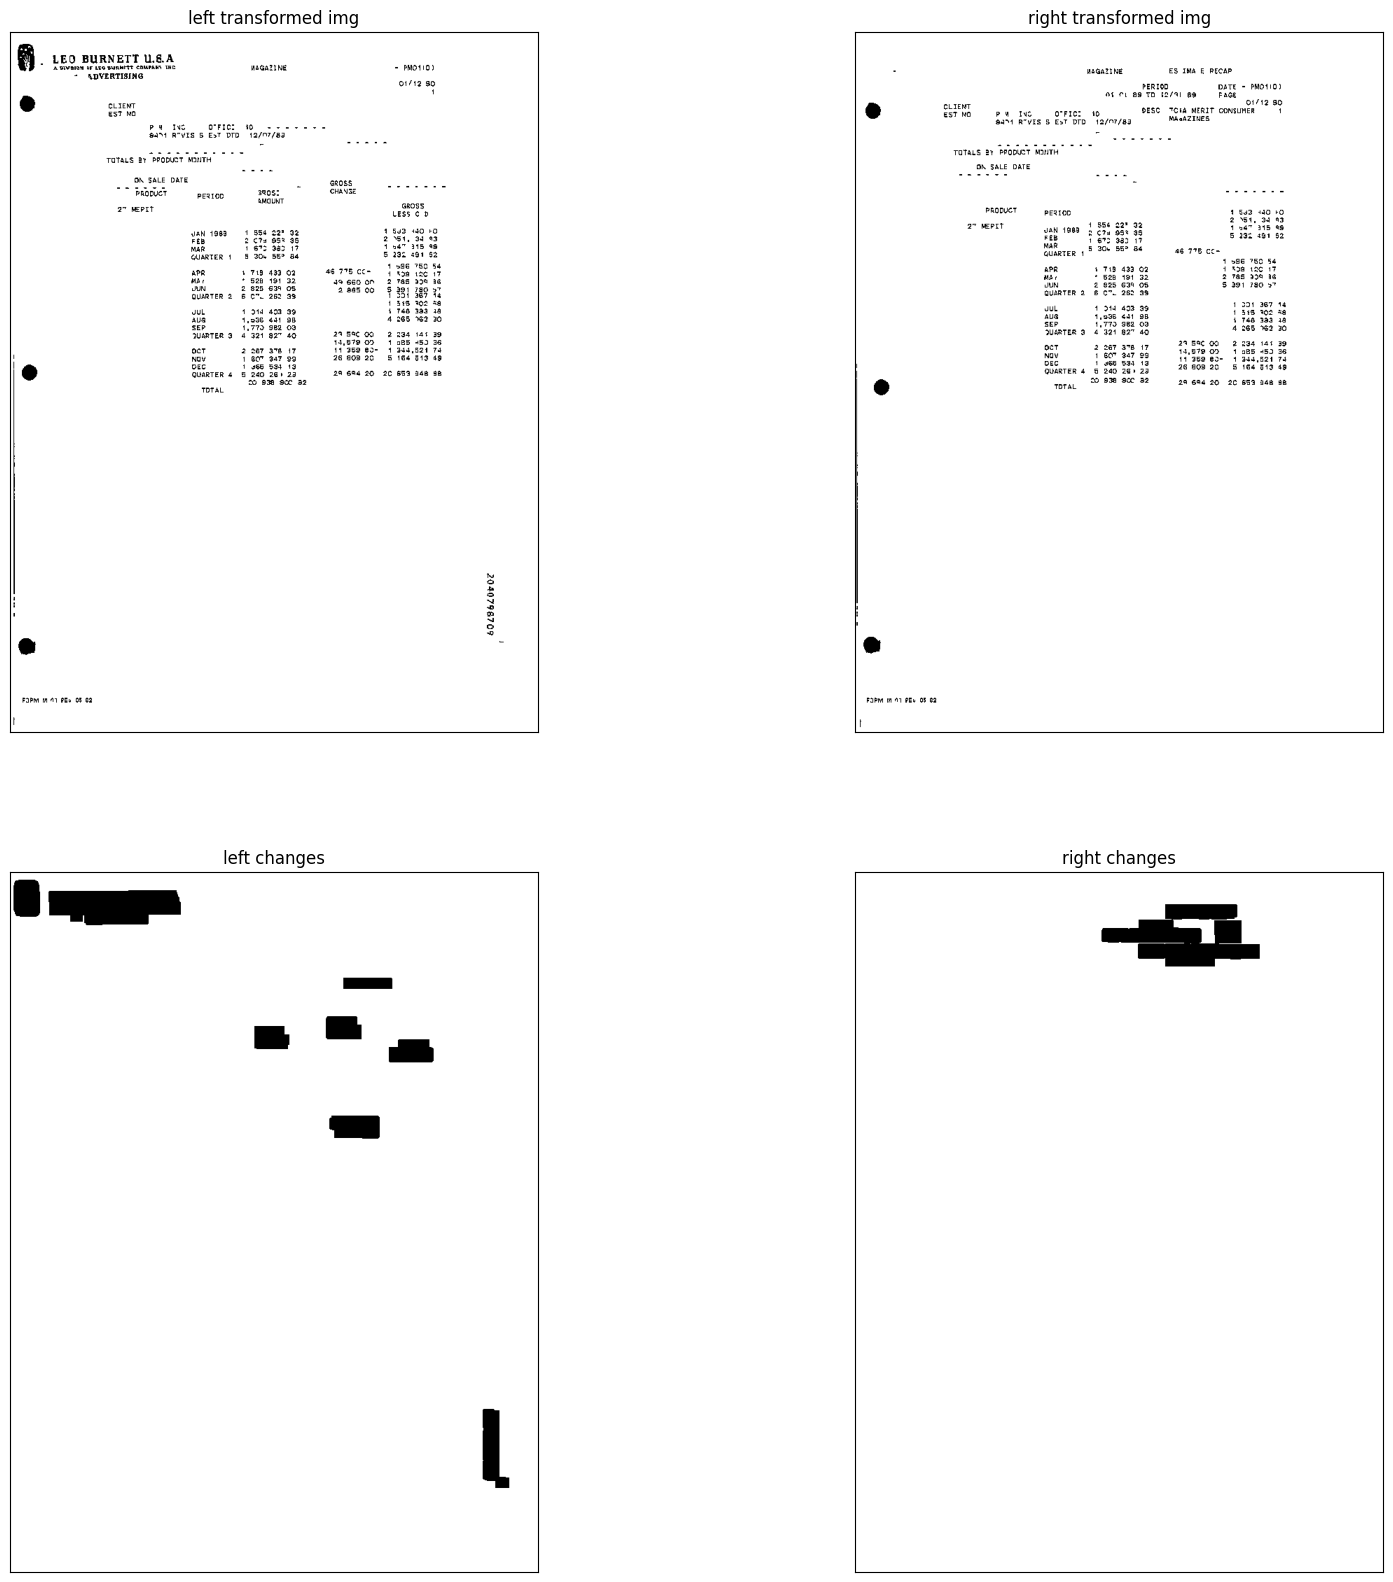

In [99]:
dataset = 'rvl2k_thick_labels'
data_path = f'generated_data\\{dataset}\\train\\'
# data_path = 'D:\\DocDiffGeneratedData\\'
images = glob(data_path+'label\\*.png')
print(f'There are {len(images)} images in this folder')

image_name = ''
if not image_name:
    image_name = os.path.basename(np.random.choice(images))
elif not image_name.endswith('.png'):
    image_name += '.png'

left_transformed_img = cv2.imread(data_path + 'A\\' + image_name)
right_transformed_img = cv2.imread(data_path + 'B\\' + image_name)
label = cv2.imread(data_path + 'label\\' + image_name)

print(image_name)
show_data(left_transformed_img, right_transformed_img, label[:,:,1], label[:,:,2])